# Imports and initialization

In [1]:
import sys
sys.path.append('/users/varverak/src/hipace/tools/')
sys.path.append('/users/varverak/PositronPWFA/analysis/')

import defs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy import constants
from mpl_toolkits.axes_grid1 import make_axes_locatable

import read_insitu_diagnostics as diag

max_step = 1 # 800
r = True
n = True

eta = 8

sub = 'front_initial'
# sub = 'front_initial_propagated' # 8 % efficiency
# sub = 'front_initial_eta16'
# sub = 'front_eta16_offset_check'
# sub = 'front_initial_eta22'
# sub = 'front_initial_offset_test'
# sub = 'LESS_OLD_front_propagated_recovery_offset_1.0_sigma'
# sub = 'NO_TRUNC_front_propagated_recovery_offset_1.0_sigma'
# sub = 'front_propagated_recovery_offset_1.0_sigma' # 8 % efficiency (400 steps)
# sub = 'front_propagated_recovery_offset_1.0_sigma_800_steps' # 8 % efficiency
# sub = 'front_propagated_recovery_offset_0.2_sigma_800_steps' # 8 % efficiency
# sub = f'front_initial_eta{eta}_propagated'
# sub = f'front_eta{eta}_propagated_recovery_offset_1.0_sigma_800_steps'
# sub = f'front_eta{eta}_propagated_recovery_offset_0.2_sigma_800_steps'

p = f'/scratch/project_465001379/varverak/hdf5/{sub}/'
ip = f'/scratch/project_465001379/varverak/insitu/{sub}/'

data = defs.Functions(path = p, insitu_path = ip, n0 = 5e16, iteration = max_step-1, normalized = n, recovery = r, mesh_refinement = True, src_path = '/users/varverak/src/hipace/')

### Plotting init

In [4]:
import matplotlib.colors as mcolors
import matplotlib as mpl

formatter = plt.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
# plt.rc('text', usetex = True)
plt.rcParams['lines.linewidth'] = 0.65

def sci():
    ax=plt.gca()
    ax.yaxis.set_major_formatter(formatter)
    return

def customCMAP(names = ['RdBu', 'PuOr', 'PRGn', 'bwr_r', 'PuOr_r', 'seismic_r'], ncolors: int = 256):

        for cmap in names:
            # if custom version of cmap already exists, skip it
            if cmap + 'T' in plt.colormaps():
                continue
            else:
                # create the colormap
                color_array = plt.get_cmap(cmap)(range(ncolors))
                color_array[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
                map_object = mcolors.LinearSegmentedColormap.from_list(name = cmap + 'T', colors = color_array)
                mpl.colormaps.register(cmap = map_object)

customCMAP()

### Correctly initialize insitu diagnostics due to parallel compute

In [22]:
p_driveInsitu = {step: data.diag.read_file(ip + f'reduced_drive.{step:04}.txt') for step in range(max_step)}
p_witnessInsitu = {step: data.diag.read_file(ip + f'reduced_witness.{step:04}.txt') for step in range(max_step)}
p_recoveryInsitu = {step: data.diag.read_file(ip + f'reduced_recovery.{step:04}.txt') for step in range(max_step)}
p_fieldInsitu = {step: data.diag.read_file(ip + f'reduced_fields.{step:04}.txt') for step in range(max_step)}
time = [p_driveInsitu[step]['time'] * data.kp_inv for step in range(max_step)]

# Calculations

In [5]:
data.quickEfficiency(0)

np.float64(8.824398094847215)

In [6]:
print(f'Drive {data.charge(q = diag.total_charge(data.driveInsitu))[0] * 1e9} nC\tWitness {data.charge(q = diag.total_charge(data.witnessInsitu))[0] * 1e9} nC\tRecovery {data.charge(q = diag.total_charge(data.recoveryInsitu))[0] * 1e9} nC')

Drive -5.157642042544539 nC	Witness 0.11677770885407689 nC	Recovery -1.4942456634610548 nC


In [6]:
data.transverse_u_std_matched(data.driveInsitu, normalized=True)

np.float64(8.484670459826171)

In [7]:
data.transverse_u_std_matched(data.recoveryInsitu, normalized=True)

np.float64(2.1207162708797465)

In [8]:
data.transverse_u_std_matched(data.witnessInsitu, normalized=True)

np.float64(2.121667056190059)

In [9]:
data.epsMatched(data.witnessInsitu, normalized=True)

np.float64(1.5129118453490524e-06)

In [10]:
data.kBeta(data.witnessInsitu)

np.float64(297.53689126403384)

In [11]:
w = data.emittance(0.03, data.transverse_u_std_matched(data.witnessInsitu, normalized=True), True)
iw = diag.emittance_x(data.witnessInsitu['average'])

print(w,iw[0]*data.kp_inv)

1.5126646503905525e-06 1.5126678868593612e-06


In [10]:
x = 0.03
data.emittance(x, x*np.sqrt(5000), True)

1.5124174564636967e-06

# Particle stuff

In [6]:
import openpmd_viewer

In [29]:
?openpmd_viewer.ParticleTracker

Init signature:
openpmd_viewer.ParticleTracker(
    ts,
    species=None,
    t=None,
    iteration=None,
    select=None,
    preserve_particle_index=False,
)
Docstring:     
Class that allows to select particles at a given iteration
(by initializing an instance of this class) and then
to return the same particles at another iteration (by passing
this instance as the argument `select` of the method `get_particle`
of an `OpenPMDTimeSeries`)

Usage
-----
Here is a minimal example of how this class is used.
In this example, all the particles in the simulation box at iteration 300
are selected, and then the position of the same particles at iteration 400
(or at least of those particles that remained in the simulation box at
iteration 400) are returned.
```
>>> ts = OpenPMDTimeSeries('./hdf5_directory/')
>>> pt = ParticleTracker( ts, iteration=300 )
>>> x, = ts.get_particle( ['x'], select=pt, iteration=400 )
```
For more details on the API of ParticleTracker, see the docstring of
the `__in

/pfs/lustrep4/users/varverak/myvenv/lib/python3.11/site-packages/openpmd_viewer/openpmd_timeseries/plotter.py:406: UserWarning: 
CIC particle histogramming is unavailable because 
Numba is not installed. NGP histogramming is used instead.
Please considering installing numba (e.g. `pip install numba`)
  warnings.warn(


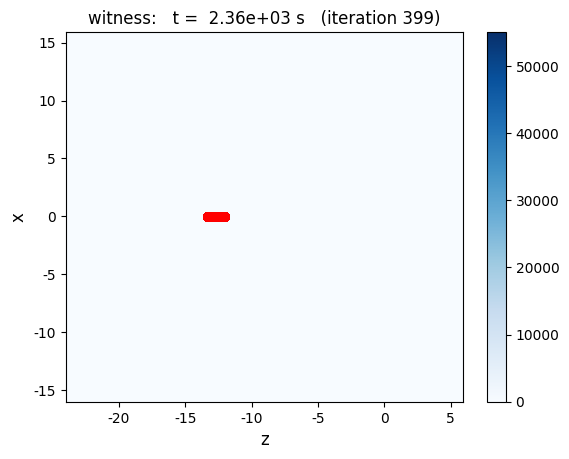

In [10]:
std_x = 0.03 # data.diag.position_std(p_witnessInsitu[0]['average'])[0]
iteration = max_step-1
zw, xw = data.ts.get_particle(var_list = ['z', 'x'], species = 'witness', iteration = iteration, plot=True)
zw_sel, xw_sel = data.ts.get_particle(var_list = ['z', 'x'], species = 'witness', iteration = iteration, select = {'x':[-5*std_x, 5*std_x]})
plt.plot(zw_sel, xw_sel, 'r.')
plt.show()

In [36]:
len(zw_sel)/len(zw)

0.9820113148986743

In [110]:
sum(p_witnessInsitu[399]['Np'][0])

np.int32(184051140)

In [111]:
s_x_scale = 6

# xw = data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = 0)
# xw_end = data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = 399)

# xw_sel = data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = 0, select = {'x':[-s_x_scale*std_x, s_x_scale*std_x]})
# xw_end_sel = data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = 399, select = {'x':[-s_x_scale*std_x, s_x_scale*std_x]})

selected_charge = np.empty(len(data.ts.iterations))

for idx,itn in enumerate(data.ts.iterations):
    print(itn)
    charge_per_macro_particle = data.charge(diag.total_charge(p_witnessInsitu[itn])) / len(data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = itn)[0])
    x_pad = s_x_scale * data.diag.position_std(p_witnessInsitu[itn]['average'])[0]
    x_center = p_witnessInsitu[itn]['average']['[x]']
    selected_charge[idx] = charge_per_macro_particle * len(data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = itn, select = {'x':[x_center - x_pad, x_center + x_pad]})[0])


0


/tmp/ipykernel_149872/2507808790.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  selected_charge[idx] = charge_per_macro_particle * len(data.ts.get_particle(var_list = ['x'], species = 'witness', iteration = itn, select = {'x':[x_center - x_pad, x_center + x_pad]})[0])


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
399


In [82]:
selected_charge

array([1.16766424e-10, 1.16766424e-10, 1.16766424e-10, 1.16766422e-10,
       1.16766302e-10, 1.16766391e-10, 1.16766382e-10, 1.16764789e-10,
       1.16754834e-10, 1.16764958e-10, 1.16744874e-10, 1.16729306e-10,
       1.16740077e-10, 1.16727707e-10, 1.16723809e-10, 1.16726241e-10,
       1.16728720e-10, 1.16733693e-10, 1.16730539e-10, 1.16731260e-10,
       1.16737156e-10, 1.16738535e-10, 1.16737587e-10, 1.16744358e-10,
       1.16750276e-10, 1.16748826e-10, 1.16749709e-10, 1.16754526e-10,
       1.16755267e-10, 1.16756677e-10, 1.16758265e-10, 1.16753886e-10,
       1.16713994e-10, 1.16640480e-10, 1.16571004e-10, 1.16577324e-10,
       1.16586847e-10, 1.16587349e-10, 1.16580304e-10, 1.16576794e-10,
       1.16582048e-10])

In [112]:
len(data.ts.iterations)

41

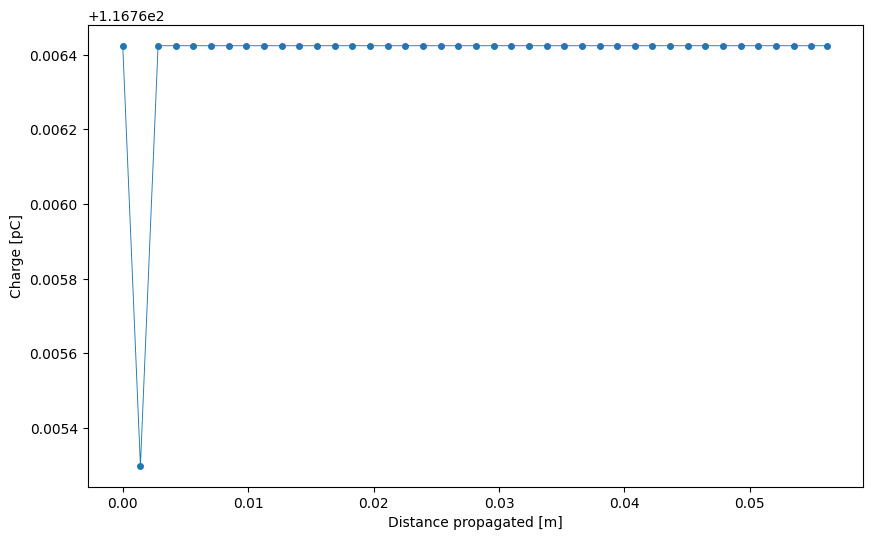

In [113]:
plt.close()
plt.figure(figsize = (10, 6))
plt.plot([time[itn] for itn in data.ts.iterations], 1e12 * selected_charge, '-o', markersize=4)
plt.xlabel('Distance propagated [m]')
plt.ylabel('Charge [pC]')
plt.show()

In [78]:
print(len(xw[0]))
print(len(xw_sel[0]))
print(len(xw_end[0]))
print(len(xw_end_sel[0]))

200000000
199999992
184051140
182705776


In [69]:
wq0 = data.charge(diag.total_charge(p_witnessInsitu[0]))

charge_per_macro_particle = wq0 / len(xw[0]) # C

In [67]:
wq_end = data.charge(diag.total_charge(p_witnessInsitu[399]))

charge_per_macro_particle = wq_end / len(xw_end[0]) # C

In [70]:
charge_per_macro_particle

array([5.83832119e-19])

# Plots

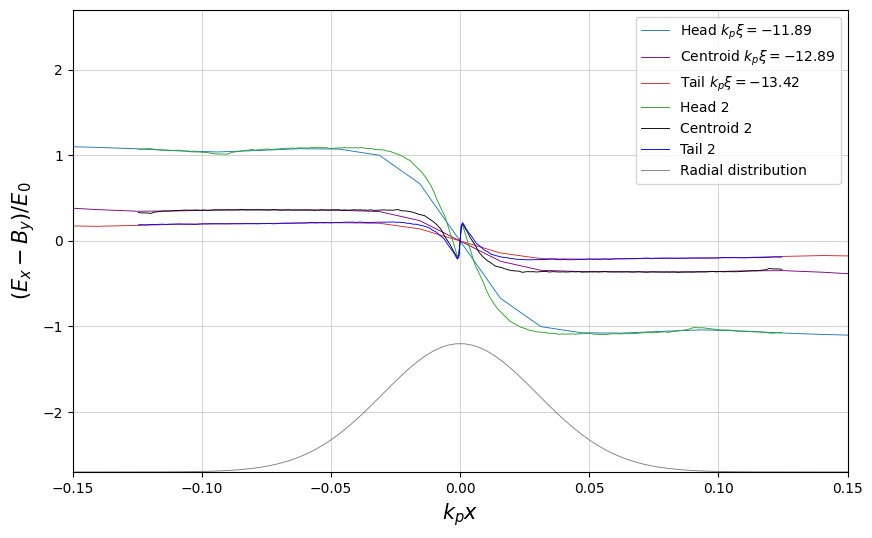

In [38]:
# focusing field (transverse slice)

sigma_x = .03

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]
kpz = -12.5
choice = np.argmin(np.abs(zAx - kpz))
centroid = np.argmin(np.abs(zAx - -12.89))
# head = np.argmin(np.abs(zAx - max(beam)))
head = np.argmin(np.abs(zAx - -11.9))
# tail = np.argmin(np.abs(zAx - min(beam)))
tail = np.argmin(np.abs(zAx - -13.42))
# mid = head - (head - tail)//2

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(data.info.x, data.ExmBy[head], 'tab:blue', ls = '-', label = f'Head $k_p\\xi = {zAx[head]:.2f}$')
plt.plot(data.info.x, data.ExmBy[centroid], 'purple', ls = '-', label = f'Centroid $k_p\\xi = {zAx[centroid]:.2f}$')
plt.plot(data.info.x, data.ExmBy[tail], 'tab:red', ls = '-', label = f'Tail $k_p\\xi = {zAx[tail]:.2f}$')
plt.plot(data.info_lev1.x, data.ExmBy_lev1[head], 'tab:green', ls = '-', label = f'Head 2')
plt.plot(data.info_lev1.x, data.ExmBy_lev1[centroid], 'k', ls = '-', label = f'Centroid 2')
plt.plot(data.info_lev1.x, data.ExmBy_lev1[tail], 'b', ls = '-', label = f'Tail 2')
# plt.plot(data.info.x, data.ExmBy[choice], 'm', ls = '-', label = f'$k_p\\xi = {zAx[choice]:.2f}$')

# ax = plt.gca()
# ax.axhline(0, c='gray', ls='--')
# ax.axvline(0, c='gray', ls='--')
plt.grid(lw=0.4)

# ax.axvline(sigma_x, c='r', ls='--')
# ax.axvline(-sigma_x, c='r', ls='--')

x = np.linspace(-5*sigma_x, 5*sigma_x, 100)
plt.plot(x, 1.5 * np.exp( -1/2 * np.power(x, 2) / sigma_x**2 ) - 2.7, 'gray', label='Radial distribution')

plt.ylabel('$(E_x-B_y)/E_0$', fontsize=15)
plt.xlabel('$k_px$', fontsize=15)
# plt.title(f'$k_p\zeta = {kpz}$')
plt.ylim(-2.7, 2.7)
# plt.xlim(data.info.xmin, data.info.xmax)
plt.xlim(-5*sigma_x, 5*sigma_x)
# plt.xlim(-.5, .5)
plt.legend(loc = 'best')
# plt.savefig('/Users/max/HiPACE/recovery/images/filamentFrontRecoTransverse.png', dpi = 300, bbox_inches = 'tight')
plt.show()

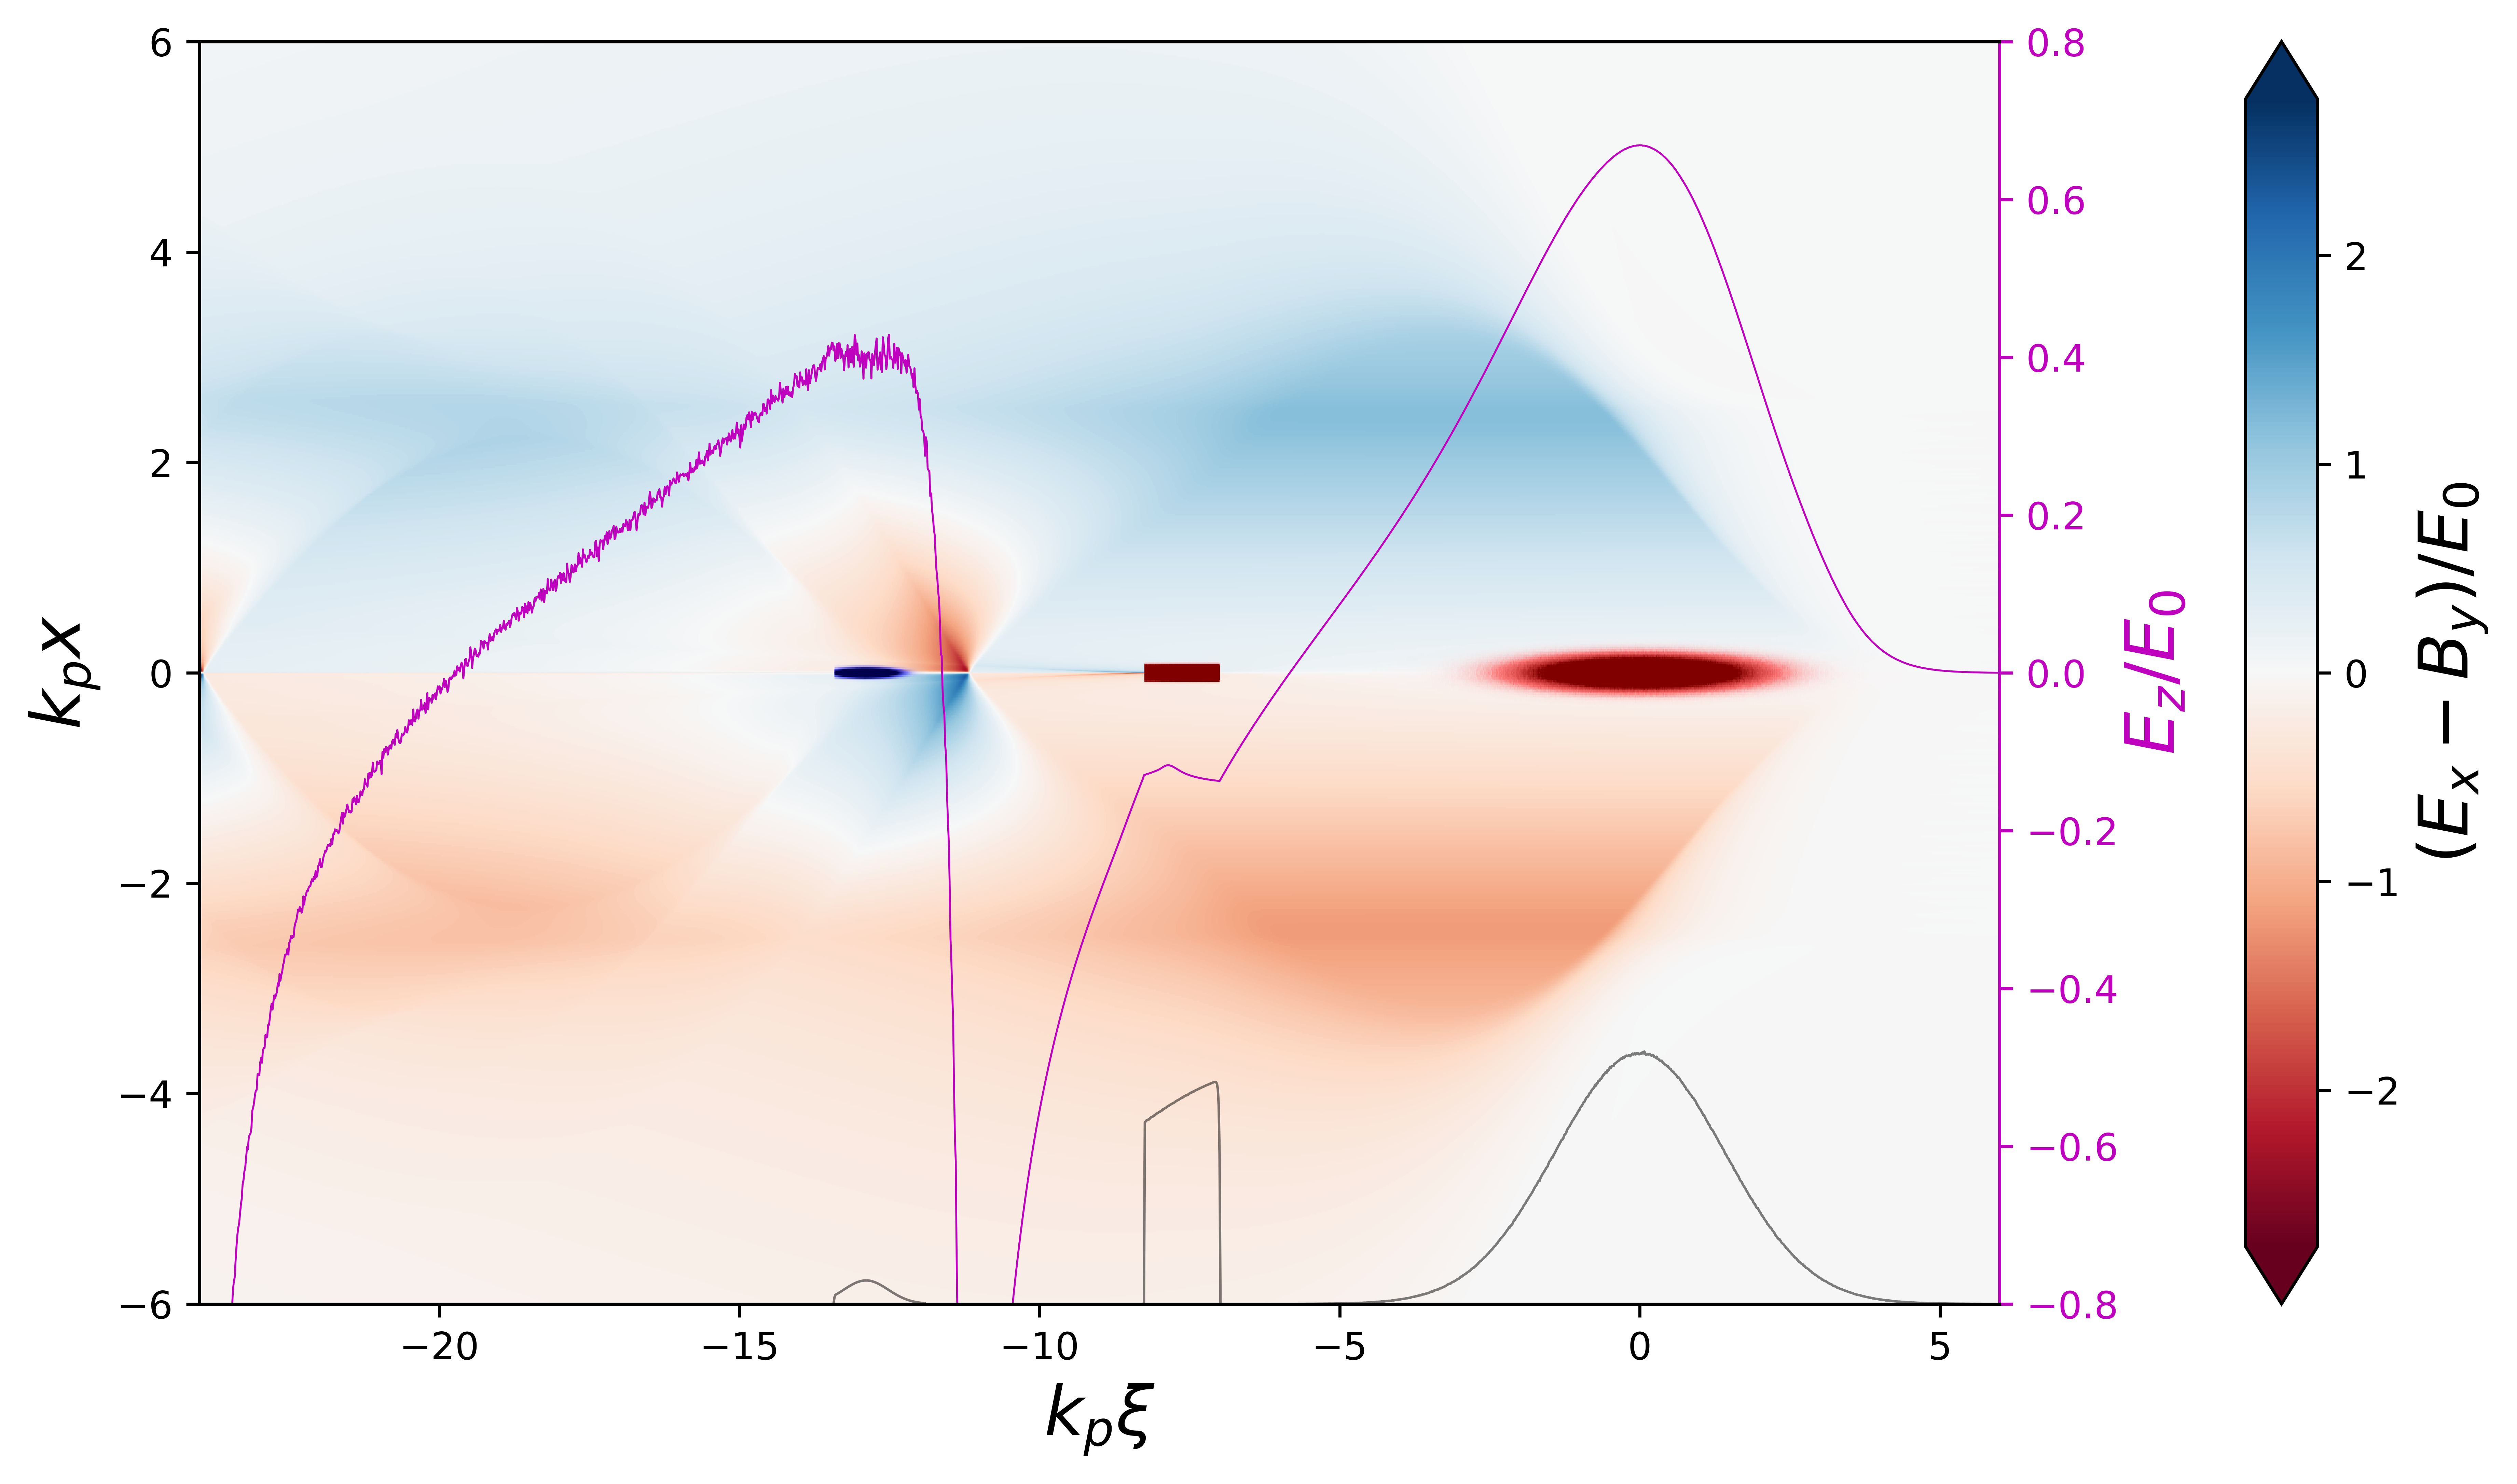

In [7]:
# Ex-By (pcolormesh)

s = 2.75
col = 'm'
pd = .9
prfl = 'k'

plt.close()
fig, axs = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 6), dpi = 800) # , gridspec_kw={'width_ratios': [1.75, 1]})
# plt.subplots_adjust(hspace=0.075)

im = axs.pcolormesh(data.info.z, data.info.x, data.ExmBy.T, cmap = 'RdBu', vmin = -s, vmax = s) # level 0
axs.pcolormesh(data.info_lev1.z, data.info_lev1.x, data.ExmBy_lev1.T, cmap = 'RdBu', vmin = -s, vmax = s) # level 1
axs.pcolormesh(data.info.z, data.info.x, data.jz_beam.T, cmap = 'seismic_rT', vmin = -7.5e1, vmax = 7.5e1) # level 0
# axs.pcolormesh(data.info_lev1.z, data.info_lev1.x, data.jz_beam_lev1.T, cmap = 'seismic_rT', vmin = -7.5e1, vmax = 7.5e1) # level 1

# axs.plot(data.info.z, 4.e-8 * data.profile[data.iteration] - 6, 'k', alpha = .5)
axs.plot(data.info.z, 4.e-8 * data.profile[0] - 6, 'k', alpha = .5)

# axs.vlines(-9.9, data.info.xmin, data.info.xmax, color = 'k', linestyle = '--', alpha = .5)

ax2 = axs.twinx()
# ax2.hlines(.4, data.info.zmin, data.info.zmax, color = col, linestyle = '--', alpha = .5)
# ax2.plot(data.info.z, data.Ez, color = col) # level 0
ax2.plot(data.info_lev1.z, data.Ez_lev1, color = col, linewidth = 0.5) # level 1
ax2.set_ylim(-.8, .8)
ax2.set_ylabel(r'$E_z/E_0$',  labelpad = 1, fontsize = 18, color = col)
ax2.spines["right"].set_color(col)
# ax2.spines["left"].set_visible(False)
ax2.tick_params(axis='y', colors=col)
divider2 = make_axes_locatable(axs)
cax2 = divider2.append_axes("right", size = "4%", pad = pd)
divider3 = make_axes_locatable(ax2)
cax3 = divider3.append_axes("right", size = "4%", pad = pd)
cax3.remove()
cb2 = plt.colorbar(im, cax = cax2, extend = 'both')
cb2.set_label(r'$(E_x - B_y)/E_0 $', fontsize = 18)

# axs.axvline(-12.5, c='k', ls='--')

# axs.axvline(-11.45, c='k', ls='--')
# axs.axvline(-7.65, c='k', ls='--')
# axs.axvline(-12.7, c='k', ls='--')
# axs.axvline(-11.5, c='k', ls='--')
# axs.axvline(-14., c='k', ls='--')

# axs.axhline(-.125, c='k', ls='--')
# axs.axhline(.125, c='k', ls='--')

axs.set_xlim(data.info.zmin, data.info.zmax)
axs.set_xlabel(r'$k_p\xi$', fontsize = 18)


axs.set_ylim(-6, 6)
axs.set_ylabel(r'$k_px$', fontsize = 18)

# plt.savefig('/users/varverak/images/front_initial.png', dpi = 300, bbox_inches = 'tight')
plt.show()

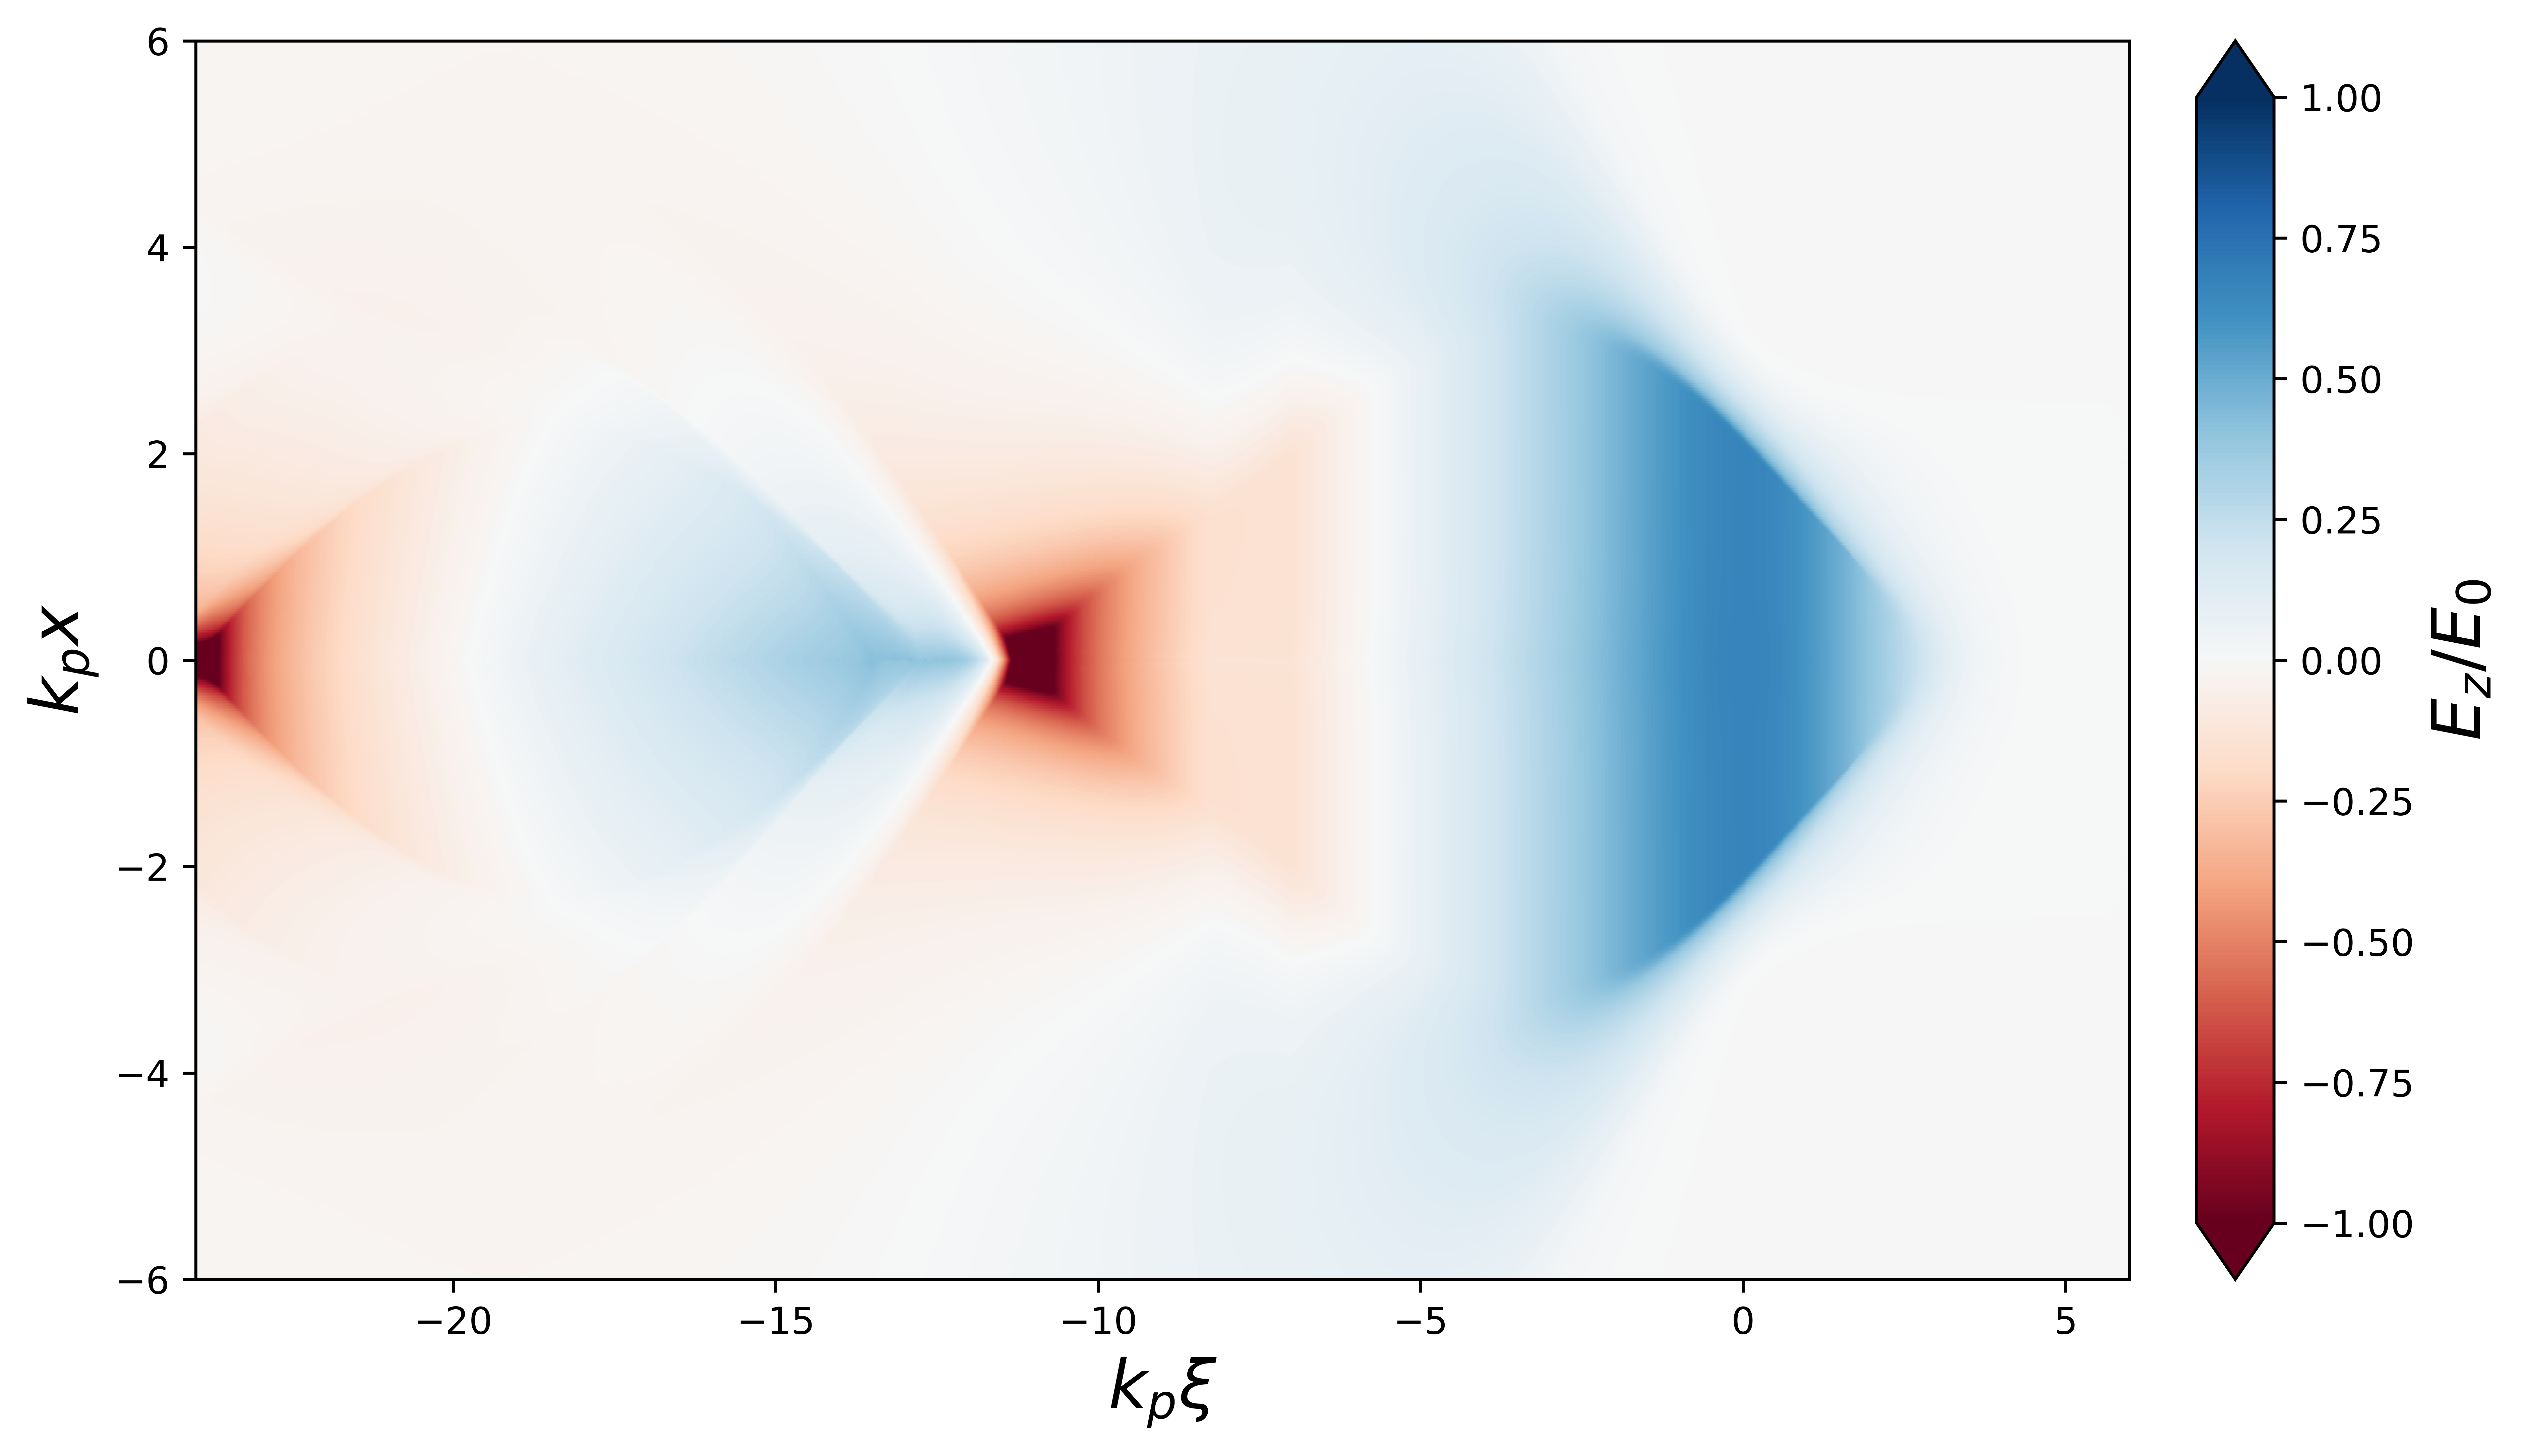

In [7]:
# Ez (pcolormesh)

s = 1.
col = 'm'
pd = .25
prfl = 'k'

plt.close()
fig, axs = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 6), dpi = 800) # , gridspec_kw={'width_ratios': [1.75, 1]})
# plt.subplots_adjust(hspace=0.075)

im = axs.pcolormesh(data.info.z, data.info.x, data.ts.get_field(field = 'Ez_lev0', iteration = 80)[0].T, cmap = 'RdBu', vmin = -s, vmax = s) # level 0
axs.pcolormesh(data.info_lev1.z, data.info_lev1.x, data.ts.get_field(field = 'Ez_lev1', iteration = 80)[0].T, cmap = 'RdBu', vmin = -s, vmax = s) # level 1
# axs.pcolormesh(data.info.z, data.info.x, data.jz_beam.T, cmap = 'seismic_rT', vmin = -7.5e1, vmax = 7.5e1) # level 0
# axs.pcolormesh(data.info_lev1.z, data.info_lev1.x, data.jz_beam_lev1.T, cmap = 'seismic_rT', vmin = -7.5e1, vmax = 7.5e1) # level 1


# axs.axvline(-13.65, c='k', ls='--')
# axs.axvline(-11.7, c='k', ls='--')
# axs.axvline(-14., c='k', ls='--')


divider2 = make_axes_locatable(axs)
cax2 = divider2.append_axes("right", size = "4%", pad = pd)
# divider3 = make_axes_locatable(ax2)
# cax3 = divider3.append_axes("right", size = "4%", pad = pd)
# cax3.remove()
cb2 = plt.colorbar(im, cax = cax2, extend = 'both')
cb2.set_label(r'$E_z/E_0 $', fontsize = 18)


axs.set_xlim(data.info.zmin, data.info.zmax)
axs.set_xlabel(r'$k_p\xi$', fontsize = 18)


axs.set_ylim(-6, 6)
axs.set_ylabel(r'$k_px$', fontsize = 18)

# plt.savefig('/Users/max/HiPACE/recovery/images/fNone.png', dpi = 300, bbox_inches = 'tight')
plt.show()

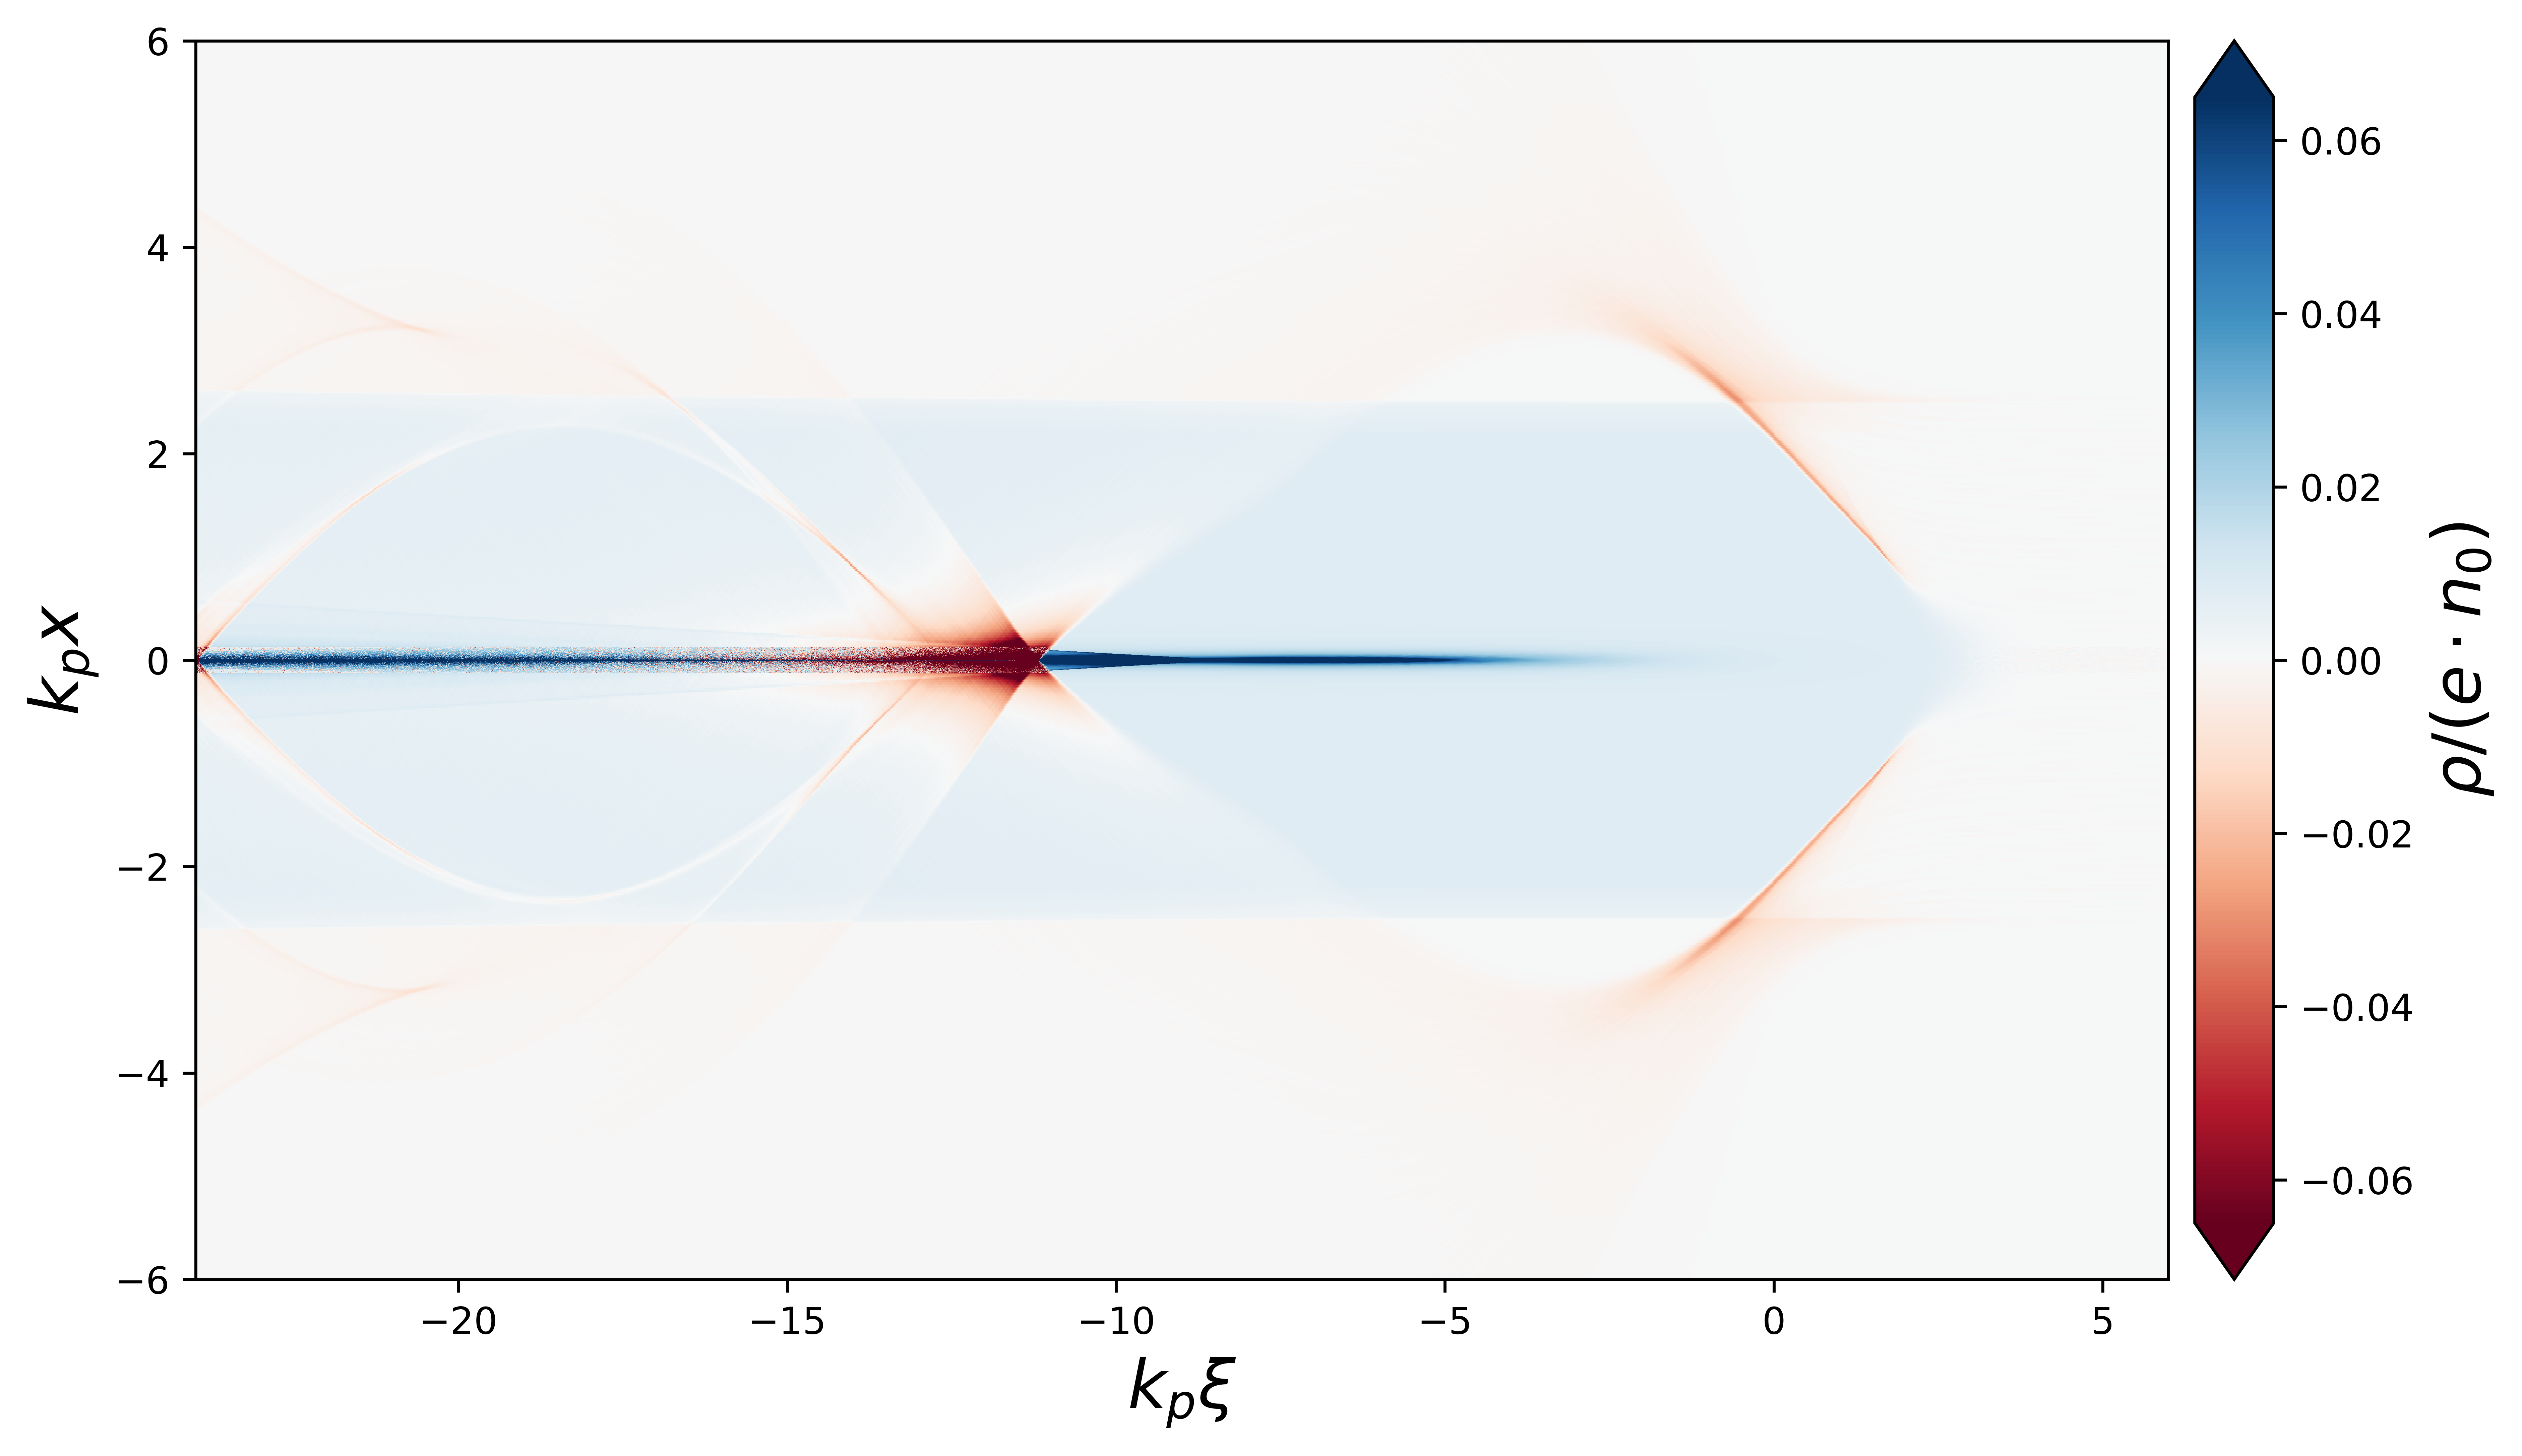

In [8]:
# rho (pcolormesh)

s = 6.5e-2
col = 'm'
pd = .1
prfl = 'k'

plt.close()
fig, axs = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 6), dpi = 800) # , gridspec_kw={'width_ratios': [1.75, 1]})
# plt.subplots_adjust(hspace=0.075)

im = axs.pcolormesh(data.info.z, data.info.x, data.ts.get_field(field = 'rho_lev0', iteration = 80)[0].T*(constants.e * data.n0), cmap = 'RdBu', vmin = -s, vmax = s) # level 0
axs.pcolormesh(data.info_lev1.z, data.info_lev1.x, data.ts.get_field(field = 'rho_lev1', iteration = 80)[0].T*(constants.e * data.n0), cmap = 'RdBu', vmin = -s, vmax = s) # level 1
# axs.pcolormesh(data.info.z, data.info.x, data.jz_beam.T * IA, cmap = 'RdBuT', vmin = -1e15, vmax = 1e15) # level 0
# axs.pcolormesh(data.info_lev1.z, data.info_lev1.x, data.jz_beam_lev1.T * IA, cmap = 'PuOrT', vmin = -1e4, vmax = 1e4) # level 1

# axs.axvline(-11.7, c='k', ls='--')
# axs.axvline(-14., c='k', ls='--')

divider2 = make_axes_locatable(axs)
cax2 = divider2.append_axes("right", size = "4%", pad = pd)
# divider3 = make_axes_locatable(ax2)
# cax3 = divider3.append_axes("right", size = "4%", pad = pd)
# cax3.remove()
cb2 = plt.colorbar(im, cax = cax2, extend = 'both')
cb2.set_label(r'$\rho/(e \cdot n_0) $', fontsize = 18)


axs.set_xlim(data.info.zmin, data.info.zmax)
axs.set_xlabel(r'$k_p\xi$', fontsize = 18)


axs.set_ylim(-6, 6)
axs.set_ylabel(r'$k_px$', fontsize = 18)

# plt.savefig('/Users/max/HiPACE/recovery/images/fNone.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
# normalized u_z

j=max_step-1

zd, uzd = data.ts.get_particle(var_list = ['z', 'uz'], species = 'drive', iteration = j)
zw, uzw = data.ts.get_particle(var_list = ['z', 'uz'], species = 'witness', iteration = j)
zr, uzr = data.ts.get_particle(var_list = ['z', 'uz'], species = 'recovery', iteration = j)


plt.close()
plt.figure(figsize = (10, 6))
plt.scatter(zd, uzd, s = 0.001, edgecolor = 'darkred')
plt.scatter(zr, uzr, s = 0.001, edgecolor = 'green')
plt.scatter(zw, uzw, s = 0.001, edgecolor = 'blue')
plt.legend(['Drive beam', 'Recovery beam', 'Witness beam'], loc = 'upper right')
# plt.axvline(-11.45, c='k', ls='--')
plt.xlabel(r'$k_p\xi$')
# plt.ylabel('E [MeV]')
plt.ylabel(r'$u_z/(m_e c)$')
sci()
plt.savefig(f'/users/varverak/images/u_z_front_800_steps_eta_{eta}_baseline.png', dpi = 500, bbox_inches = 'tight')
plt.show()

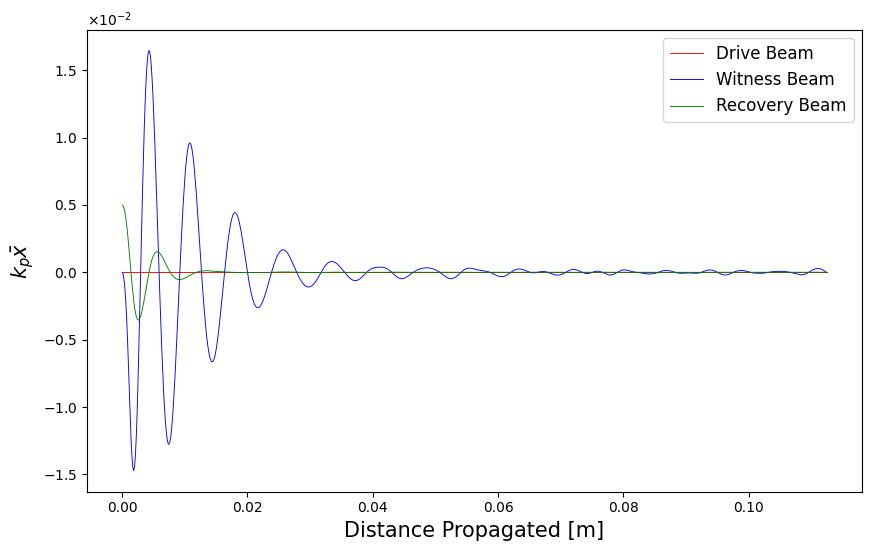

In [25]:
# avg. x

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [p_driveInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [p_witnessInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [p_recoveryInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]', fontsize=15)
plt.ylabel('$k_p\\bar{x}$', fontsize=15)
plt.legend(fontsize=12)
sci()
plt.savefig(f'/users/varverak/images/avg_x_front_800_steps_eta_{eta}_0.2_sigma_recovery_offset.png', dpi = 500, bbox_inches = 'tight')
plt.show()

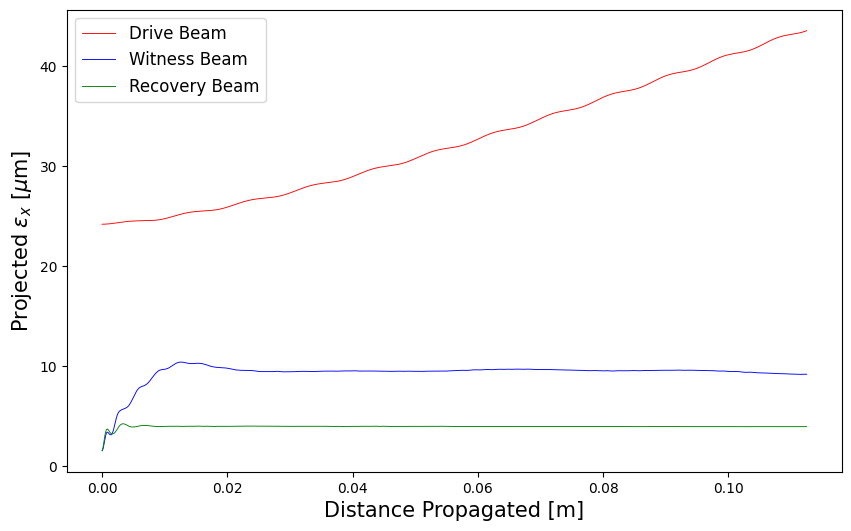

In [26]:
# projected x-emittance [um]

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [data.kp_inv * 1e6 * diag.emittance_x(p_driveInsitu[step]['average']) for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [data.kp_inv * 1e6 * diag.emittance_x(p_witnessInsitu[step]['average']) for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [data.kp_inv * 1e6 * diag.emittance_x(p_recoveryInsitu[step]['average']) for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]', fontsize=15)
plt.ylabel('Projected $\epsilon_x$ [$\mu$m]', fontsize=15)
plt.legend(fontsize=12)
plt.savefig(f'/users/varverak/images/emittance_x_front_800_steps_eta_{eta}_0.2_sigma_recovery_offset.png', dpi = 500, bbox_inches = 'tight')
plt.show()

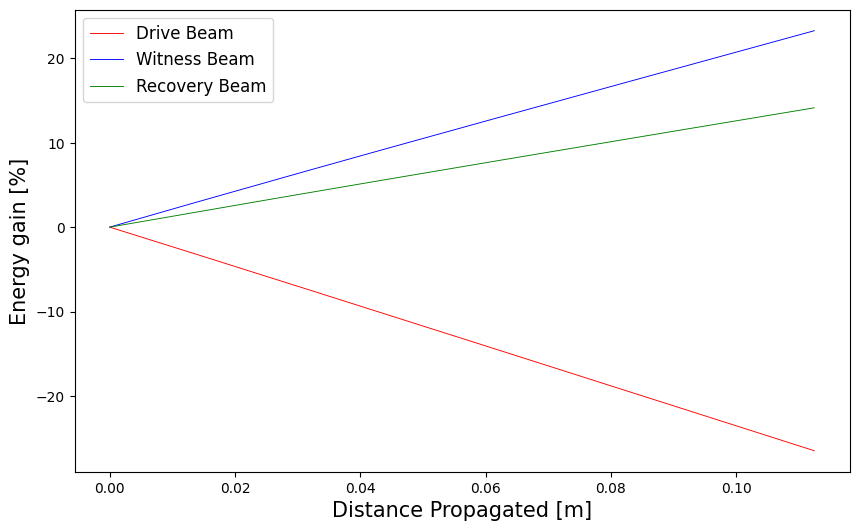

In [27]:
# energy gain [%]

dE0 = diag.energy_mean_eV(p_driveInsitu[0])
wE0 = diag.energy_mean_eV(p_witnessInsitu[0])
rE0 = diag.energy_mean_eV(p_recoveryInsitu[0])

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [1e2 * (diag.energy_mean_eV(p_driveInsitu[step])/dE0 - 1) for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [1e2 * (diag.energy_mean_eV(p_witnessInsitu[step])/wE0 - 1) for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [1e2 * (diag.energy_mean_eV(p_recoveryInsitu[step])/rE0 - 1) for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]', fontsize=15)
plt.ylabel('Energy gain [%]', fontsize=15)
# plt.yticks(np.arange(-12.5, 10, 2.5))
plt.legend(fontsize=12)
plt.savefig(f'/users/varverak/images/energy_gain_front_800_steps_eta_{eta}_0.2_sigma_recovery_offset.png', dpi = 500, bbox_inches = 'tight')
plt.show()

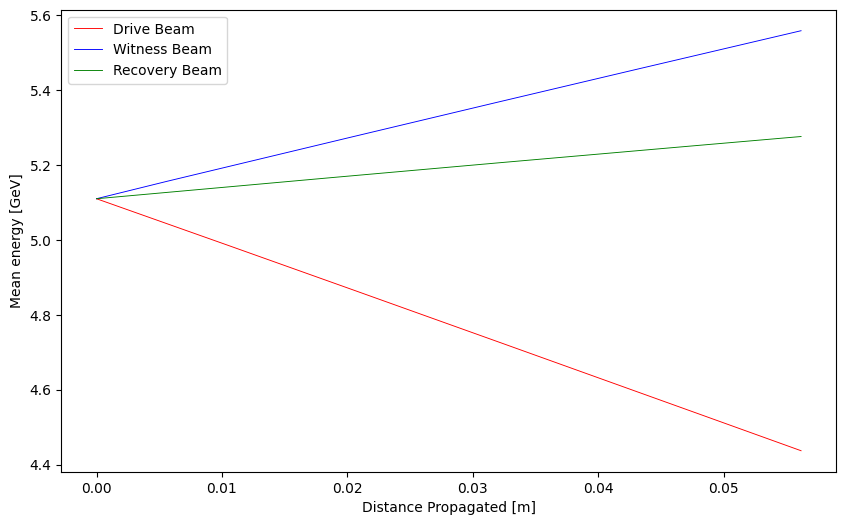

In [9]:
# mean energy [GeV]

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [1e-9 * diag.energy_mean_eV(p_driveInsitu[step]) for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [1e-9 * diag.energy_mean_eV(p_witnessInsitu[step]) for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [1e-9 * diag.energy_mean_eV(p_recoveryInsitu[step]) for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]')
plt.ylabel('Mean energy [GeV]')
plt.legend()
# plt.savefig('/Users/max/Downloads/test_frame.png', dpi = 500, bbox_inches = 'tight')
plt.show()

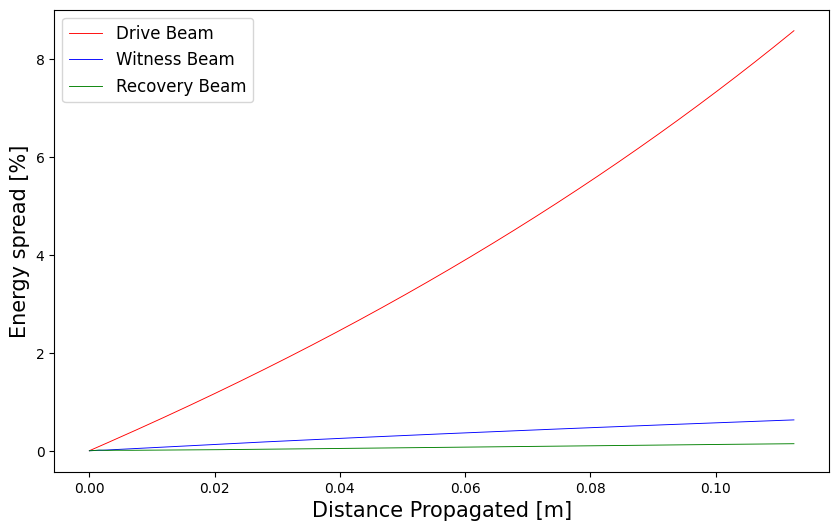

In [28]:
# energy spread [%]

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [1e2 * diag.energy_spread_eV(p_driveInsitu[step]) / diag.energy_mean_eV(p_driveInsitu[step]) for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [1e2 * diag.energy_spread_eV(p_witnessInsitu[step]) / diag.energy_mean_eV(p_witnessInsitu[step]) for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [1e2 * diag.energy_spread_eV(p_recoveryInsitu[step]) / diag.energy_mean_eV(p_recoveryInsitu[step]) for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]', fontsize=15)
plt.ylabel('Energy spread [%]', fontsize=15)
plt.legend(fontsize=12)
plt.savefig(f'/users/varverak/images/energy_spread_front_800_steps_eta_{eta}_0.2_sigma_recovery_offset.png', dpi = 500, bbox_inches = 'tight')
plt.show()

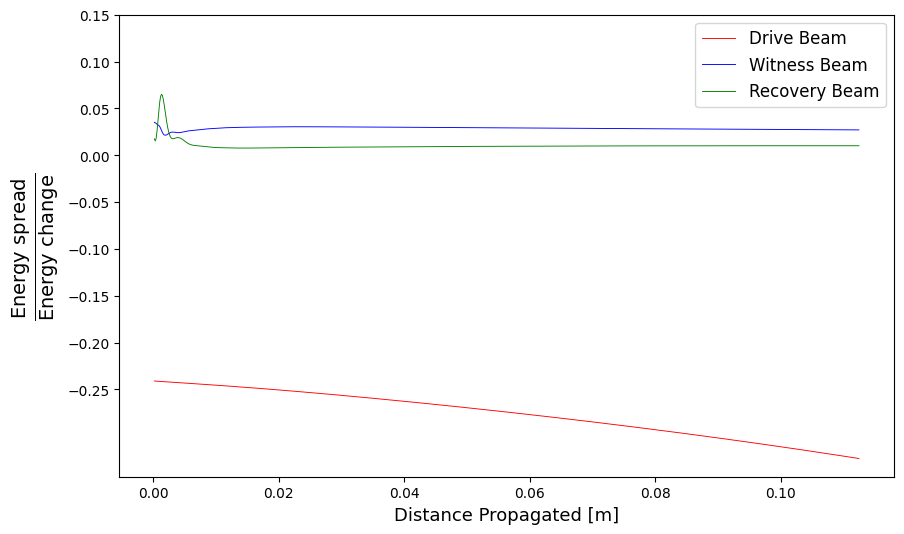

In [29]:
# energy spread / energy gain (%/%)

dE0 = diag.energy_mean_eV(p_driveInsitu[0])
wE0 = diag.energy_mean_eV(p_witnessInsitu[0])
rE0 = diag.energy_mean_eV(p_recoveryInsitu[0])

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time[1:], [(diag.energy_spread_eV(p_driveInsitu[step]) / diag.energy_mean_eV(p_driveInsitu[step])) / (diag.energy_mean_eV(p_driveInsitu[step])/dE0 - 1) for step in range(1, max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time[1:], [(diag.energy_spread_eV(p_witnessInsitu[step]) / diag.energy_mean_eV(p_witnessInsitu[step])) / (diag.energy_mean_eV(p_witnessInsitu[step])/wE0 - 1) for step in range(1, max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time[1:], [(diag.energy_spread_eV(p_recoveryInsitu[step]) / diag.energy_mean_eV(p_recoveryInsitu[step])) / (diag.energy_mean_eV(p_recoveryInsitu[step])/rE0 - 1) for step in range(1, max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]', fontsize=13)
plt.ylabel(r'$\frac{\mathrm{Energy\ spread}}{\mathrm{Energy\ change}}$', fontsize = 20)
plt.yticks(np.arange(-.25, .2, .05))
plt.legend(fontsize=12)
plt.savefig(f'/users/varverak/images/energy_spread_to_change_front_800_steps_eta_{eta}_0.2_sigma_recovery_offset.png', dpi = 500, bbox_inches = 'tight')
plt.show()

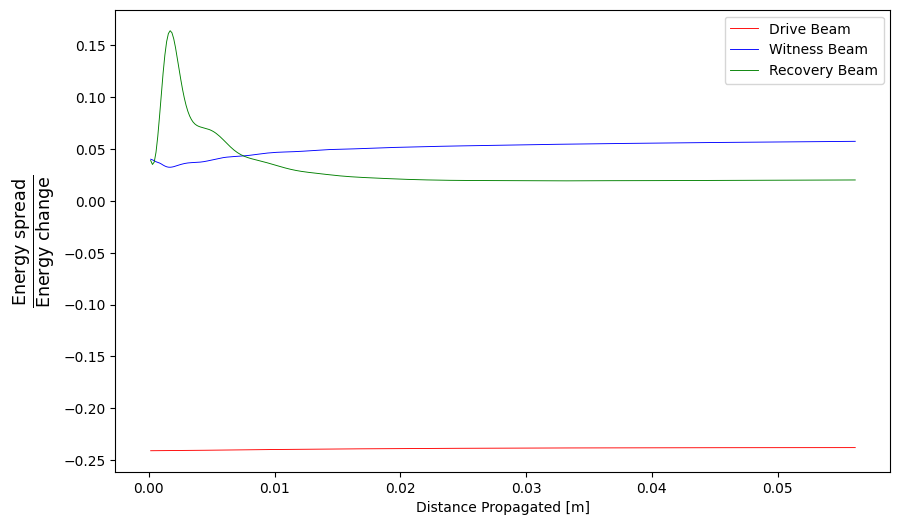

In [32]:
# energy spread / energy gain (eV/eV)

dE0 = diag.energy_mean_eV(p_driveInsitu[0])
wE0 = diag.energy_mean_eV(p_witnessInsitu[0])
rE0 = diag.energy_mean_eV(p_recoveryInsitu[0])

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time[1:], [diag.energy_spread_eV(p_driveInsitu[step]) / (diag.energy_mean_eV(p_driveInsitu[step]) - dE0) for step in range(1, max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time[1:], [diag.energy_spread_eV(p_witnessInsitu[step]) / (diag.energy_mean_eV(p_witnessInsitu[step]) - wE0) for step in range(1, max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time[1:], [diag.energy_spread_eV(p_recoveryInsitu[step]) / (diag.energy_mean_eV(p_recoveryInsitu[step]) - rE0) for step in range(1, max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]')
plt.ylabel(r'$\frac{\mathrm{Energy\ spread}}{\mathrm{Energy\ change}}$', fontsize = 18)
plt.legend()
# plt.savefig('/Users/max/Downloads/test_frame.png', dpi = 500, bbox_inches = 'tight')
plt.show()

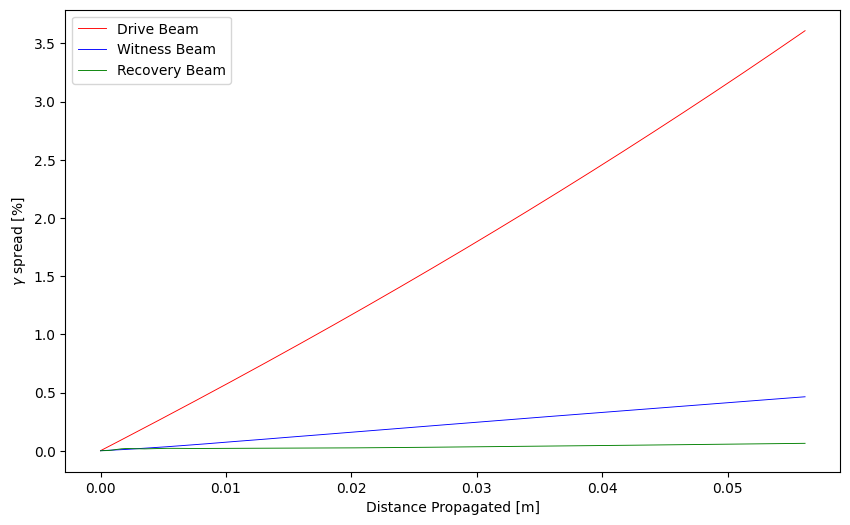

In [15]:
# gamma spread [%]

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [1e2 * diag.gamma_spread(p_driveInsitu[step]['average'])[0]/diag.gamma_mean(p_driveInsitu[step]['average'])[0] for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [1e2 * diag.gamma_spread(p_witnessInsitu[step]['average'])[0]/diag.gamma_mean(p_witnessInsitu[step]['average'])[0] for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [1e2 * diag.gamma_spread(p_recoveryInsitu[step]['average'])[0]/diag.gamma_mean(p_recoveryInsitu[step]['average'])[0] for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]')
plt.ylabel(r'$\gamma$ spread [%]')
plt.legend()
# plt.savefig('/Users/max/Downloads/test_frame.png', dpi = 500, bbox_inches = 'tight')
plt.show()

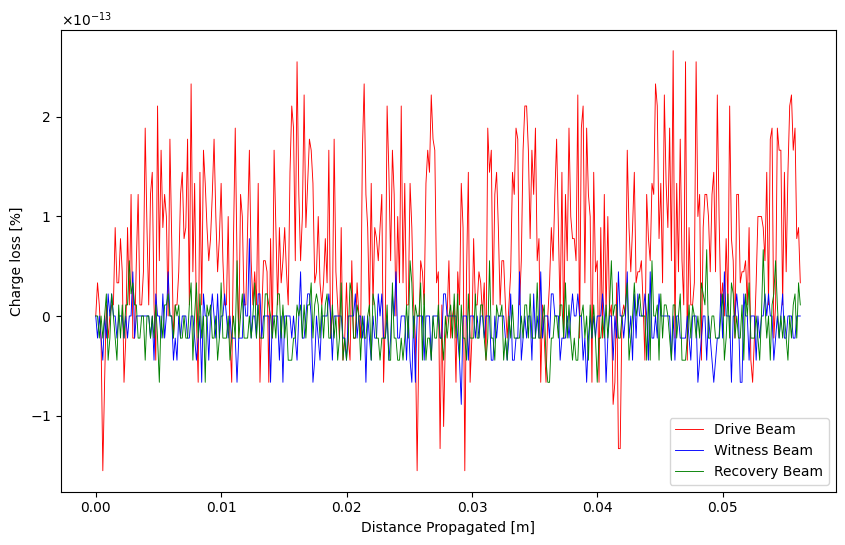

In [7]:
# total charge loss [%]

dq0 = diag.total_charge(p_driveInsitu[0])
wq0 = diag.total_charge(p_witnessInsitu[0])
rq0 = diag.total_charge(p_recoveryInsitu[0])

plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [1e2 * (1-diag.total_charge(p_driveInsitu[step])[0]/dq0) for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [1e2 * (1-diag.total_charge(p_witnessInsitu[step])[0]/wq0) for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [1e2 * (1-diag.total_charge(p_recoveryInsitu[step])[0]/rq0) for step in range(max_step)], label = 'Recovery Beam', c = 'g')
plt.xlabel('Distance Propagated [m]')
plt.ylabel('Charge loss [%]')
plt.legend()
sci()
# plt.savefig('/Users/max/Downloads/test_frame.png', dpi = 500, bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_136491/3485096092.py:13: RuntimeWarning: invalid value encountered in divide
  [1e2 * (np.divide(
/tmp/ipykernel_136491/3485096092.py:13: RuntimeWarning: divide by zero encountered in divide
  [1e2 * (np.divide(


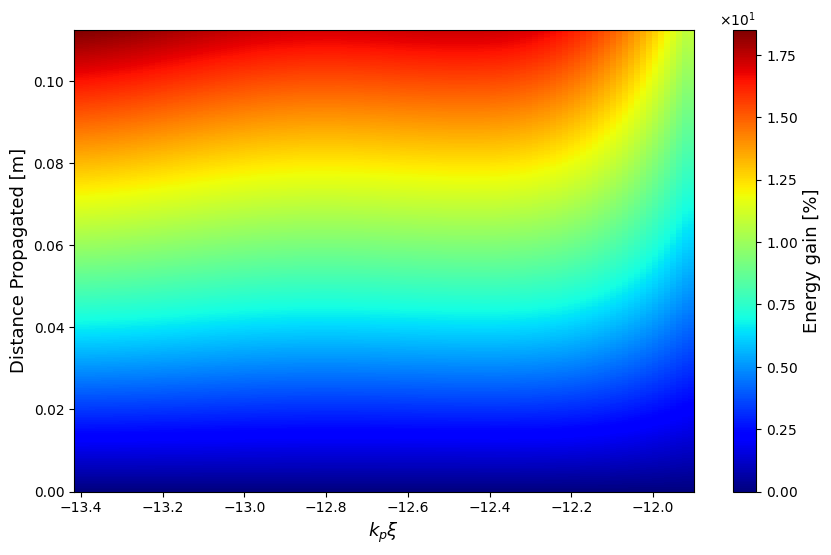

In [44]:
# per-slice energy change [%]

# ps_dE0 = diag.energy_mean_eV(p_driveInsitu[0], per_slice=True)
ps_wE0 = diag.energy_mean_eV(p_witnessInsitu[0], per_slice=True)
# ps_rE0 = diag.energy_mean_eV(p_recoveryInsitu[0], per_slice=True)

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time,
                     [1e2 * (np.divide(
                         diag.energy_mean_eV(p_witnessInsitu[step], per_slice = True)[0],
                         ps_wE0[0]
                     )-1) for step in range(max_step)],
                     # np.reshape([diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True) / 1e6 for step in range(max_step)], (400,2048)),
                     cmap = 'jet',
                     # vmin = 0.,
                     # vmax = 25.
                    )

plt.ylim(0, time[-1])
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]', fontsize=13)
plt.xlabel(r'$k_p\xi$', fontsize=13)
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label('Energy gain [%]', fontsize=13)
plt.show()

/tmp/ipykernel_159701/3522171180.py:13: RuntimeWarning: invalid value encountered in divide
  [np.divide(


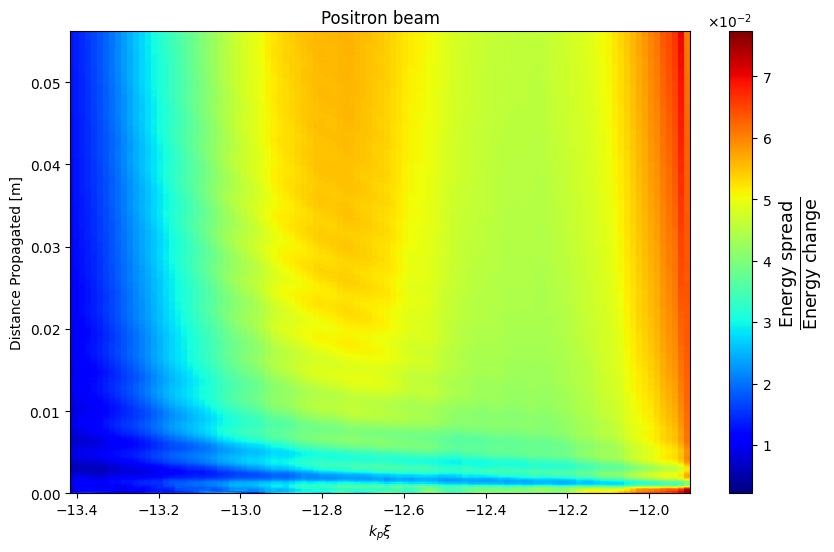

In [15]:
# per-slice energy spread / energy gain

# ps_dE0 = diag.energy_mean_eV(p_driveInsitu[0], per_slice=True)
ps_wE0 = diag.energy_mean_eV(p_witnessInsitu[0], per_slice=True)
# ps_rE0 = diag.energy_mean_eV(p_recoveryInsitu[0], per_slice=True)

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time[1:],
                     [np.divide(
                         diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True)[0],
                         diag.energy_mean_eV(p_witnessInsitu[step], per_slice = True)[0]-ps_wE0[0]
                     ) for step in range(1, max_step)],
                     # np.reshape([diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True) / 1e6 for step in range(max_step)], (400,2048)),
                     cmap = 'jet',
                     # vmin = 0.,
                     # vmax = 25.
                    )

plt.ylim(0, time[-1])
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'$\frac{\mathrm{Energy\ spread}}{\mathrm{Energy\ change}}$', fontsize = 18)
plt.title('Positron beam')
plt.show()

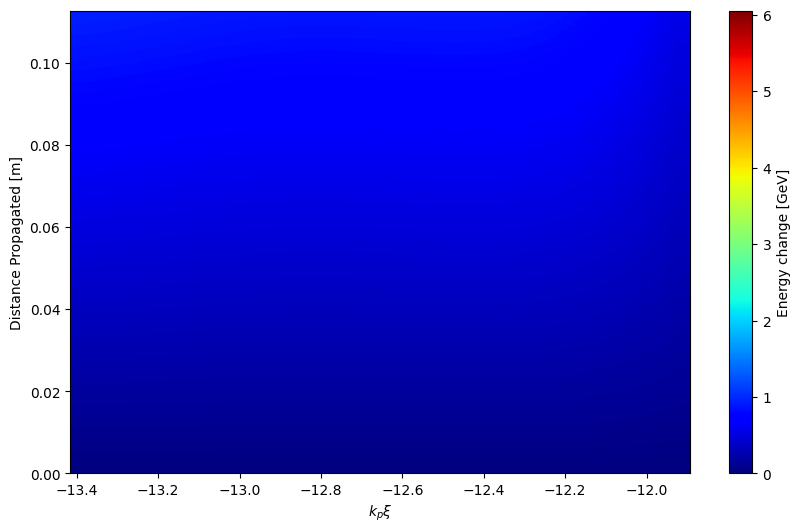

In [45]:
# per-slice mean energy [GeV]

# ps_dE0 = diag.energy_mean_eV(p_driveInsitu[0], per_slice=True)
ps_wE0 = diag.energy_mean_eV(p_witnessInsitu[0], per_slice=True)
# ps_rE0 = diag.energy_mean_eV(p_recoveryInsitu[0], per_slice=True)

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time,
                     [1e-9 * (diag.energy_mean_eV(p_witnessInsitu[step], per_slice = True)[0] - ps_wE0[0]) for step in range(max_step)],
                     cmap = 'jet',
                     # vmin = 0.,
                     # vmax = 25.
                    )

plt.ylim(0, time[-1])
plt.xlim(min(beam), max(beam))
# plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label('Energy change [GeV]')
plt.show()

/tmp/ipykernel_136491/3048145097.py:9: RuntimeWarning: invalid value encountered in divide
  [np.divide(


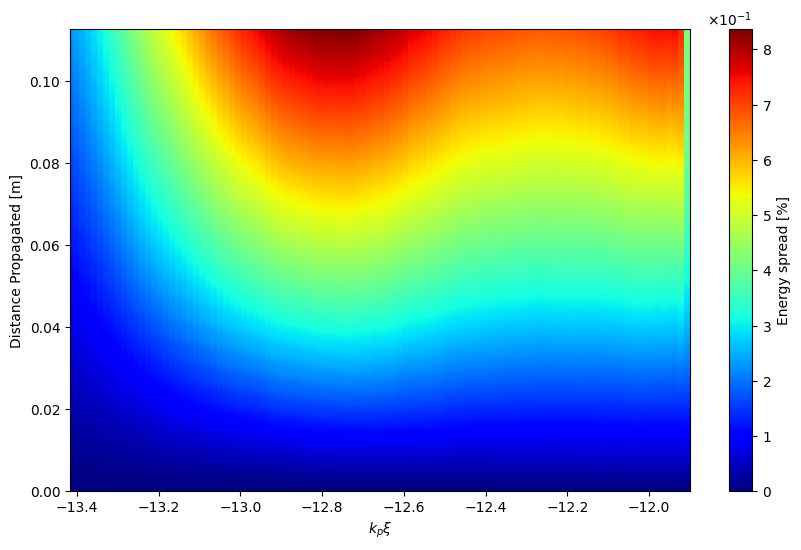

In [47]:
# per-slice energy spread [%]

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time,
                     [np.divide(
                         1e2 * diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True)[0],
                         diag.energy_mean_eV(p_witnessInsitu[step], per_slice = True)[0]
                     ) for step in range(max_step)],
                     # np.reshape([diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True) / 1e6 for step in range(max_step)], (400,2048)),
                     cmap = 'jet',
                     # vmin = 0.,
                     # vmax = 25.
                    )

plt.ylim(0, time[-1])
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label('Energy spread [%]')
plt.show()

/tmp/ipykernel_135009/2670990893.py:11: RuntimeWarning: invalid value encountered in divide
  [np.subtract(100, np.divide(


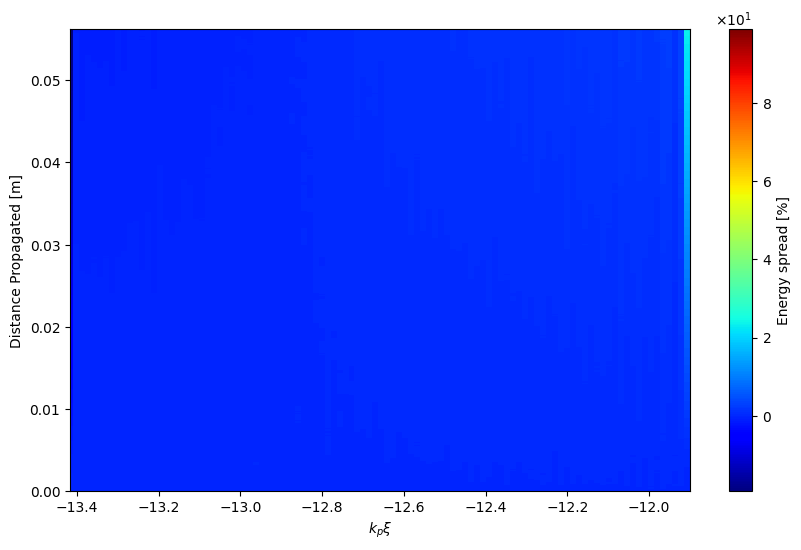

In [9]:
# per-slice charge loss [%]

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

# psl_dq0 = diag.per_slice_charge(p_driveInsitu[0])
psl_wq0 = diag.per_slice_charge(p_witnessInsitu[0])
# psl_rq0 = diag.per_slice_charge(p_recoveryInsitu[0])

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time,
                     [np.subtract(100, np.divide(
                         1e2 * diag.per_slice_charge(p_witnessInsitu[step])[0],
                         psl_wq0[0]
                     )) for step in range(max_step)],
                     # np.reshape([diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True) / 1e6 for step in range(max_step)], (400,2048)),
                     cmap = 'jet',
                     # vmin = 0.,
                     # vmax = 25.
                    )

plt.ylim(0, time[-1])
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label('Energy spread [%]')
plt.show()

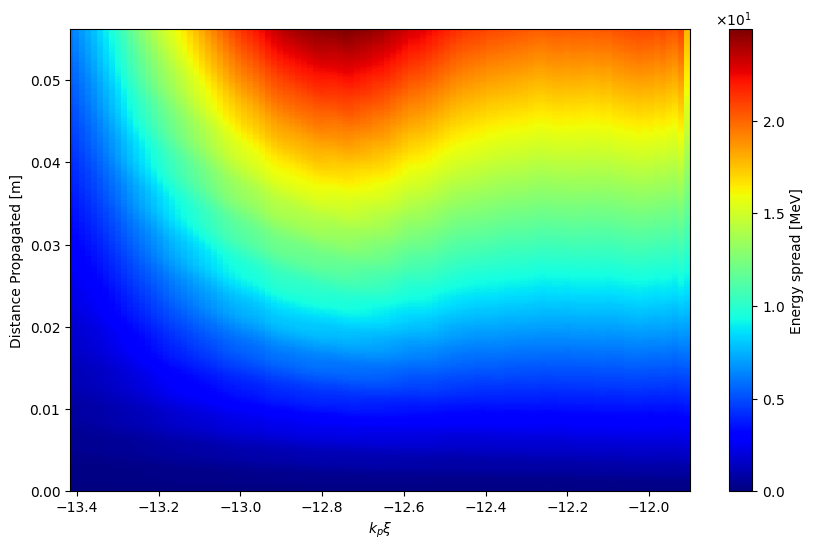

In [15]:
# per-slice energy spread [MeV]

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time,
                     [diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True)[0] / 1e6 for step in range(max_step)],
                     # np.reshape([diag.energy_spread_eV(p_witnessInsitu[step], per_slice = True) / 1e6 for step in range(max_step)], (400,2048)),
                     cmap = 'jet',
                     # vmin = 0.,
                     # vmax = 25.
                    )

plt.ylim(0, time[-1])
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label('Energy spread [MeV]')
plt.show()

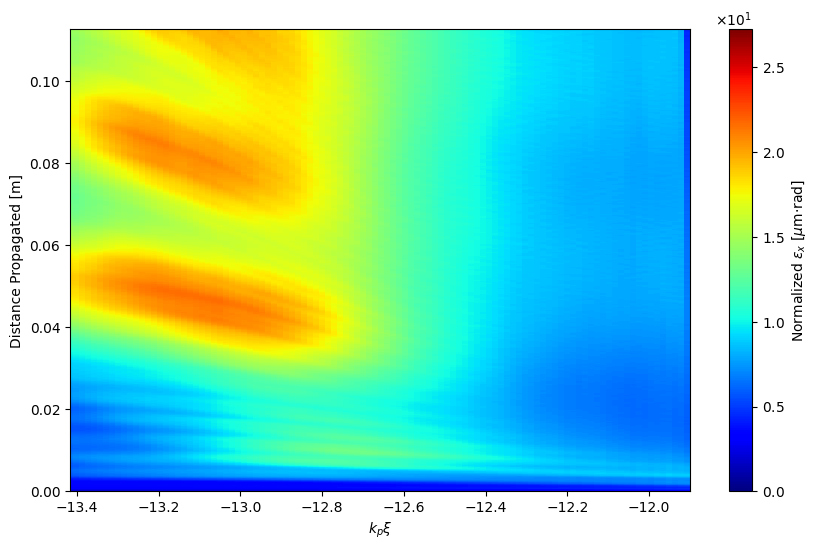

In [17]:
# per-slice x-emittance [um-rad]

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time, [diag.emittance_x(p_witnessInsitu[step])[0] * data.kp_inv * 1e6 for step in range(max_step)], cmap='jet')

plt.ylim(0, time[-1])
# plt.xlim(-13, -10)
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'Normalized $\varepsilon_x$ [$\mu$m$\cdot$rad]')
plt.show()

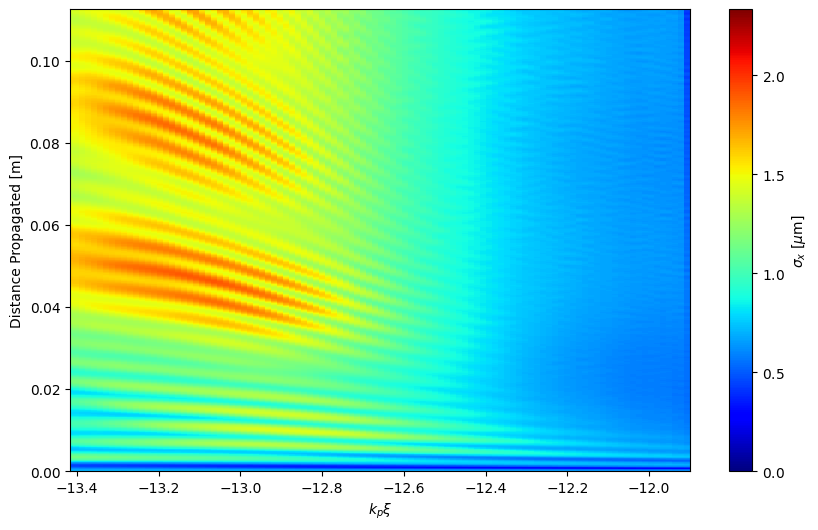

In [18]:
# per-slice sigma_x [um-rad]

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time, [diag.position_std(p_witnessInsitu[step])[0] * data.kp_inv * 1e6 for step in range(max_step)], cmap='jet')

plt.ylim(0, time[-1])
# plt.xlim(-13, -10)
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'$\sigma_x$ [$\mu$m]')
plt.show()

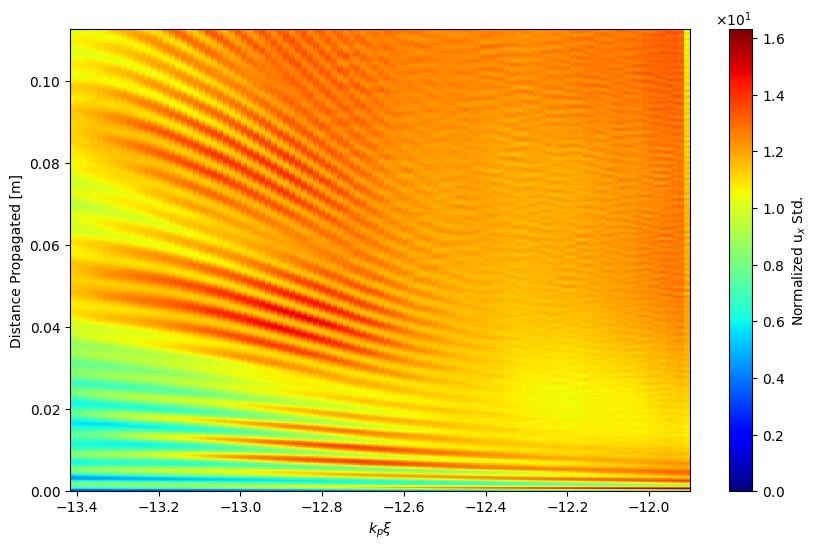

In [19]:
# per-slice normalized u_x-std

zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time, [diag.normalized_momentum_std(p_witnessInsitu[step])[0] for step in range(max_step)], cmap='jet')

plt.ylim(0, time[-1])
# plt.xlim(-13, -10)
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'Normalized u$_x$ Std.')
plt.show()

# Wake centroid

In [80]:
probe_step = 0

Ez_lev1, info_lev1 = data.ts.get_field(field = 'Ez' + data.lv1, iteration = probe_step)
ExmBy_1 = data.getZ(data.ts.get_field(field = 'ExmBy' + data.lv1, iteration = probe_step)[0], info_lev1)
ExmBy_0 = data.getZ(data.ts.get_field(field = 'ExmBy' + data.lv0, iteration = probe_step)[0], data.info)

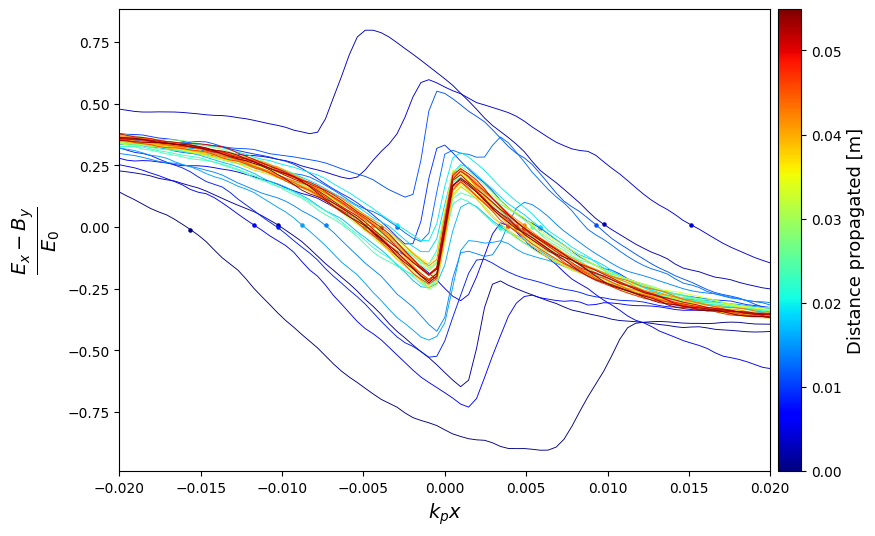

In [110]:

z = diag.z_axis(data.witnessInsitu)
witness_centroid_xi = -12.89
centroid_idx = np.argmin(abs(z - witness_centroid_xi))

cmap = plt.get_cmap('jet')
cmap2 = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1,len(time[::10])))
colors2 = cmap2(np.linspace(0,1,len(time[::10])))

x_idcs = []
wake_centroid_x = []

plt.close()
plt.figure(figsize=(10, 6))

for count,step in enumerate(range(0, 400, 10)):
    ExmBy_lev1, info_lev1 = data.ts.get_field(field = 'ExmBy' + data.lv1, iteration = step)
    # centroid_x_idx = np.argmin(abs(ExmBy_lev1[centroid_idx]))
    centroid_x_idx = np.argpartition(abs(ExmBy_lev1[centroid_idx]), 1)[:1]
    x_idcs.append(centroid_x_idx)
    wake_centroid_x.append(np.mean([ExmBy_lev1[centroid_idx][x_idx] for x_idx in centroid_x_idx]))
    


    plt.plot(info_lev1.x, ExmBy_lev1[centroid_idx] + 0*count/2, color=colors[count])
    # plt.scatter(step/10, ExmBy_lev1[centroid_idx][centroid_x_idx], c='r')
    
    for j in centroid_x_idx:
        plt.scatter(info_lev1.x[j], ExmBy_lev1[centroid_idx][j] + 0*count/2, s=5, color=colors2[count])

# i = 10
# plt.scatter(info_lev1.x[x_idcs[i]], wake_centroid_x[i], s=16, c='m')

plt.xlim(-0.02, 0.02)
plt.ylabel('$\\frac{E_x-B_y}{E_0}$', fontsize=20)
plt.xlabel('$k_p x$', fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(time[::10]), vmax=max(time[::10])))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=plt.gca(), pad=.01)
cbar.set_label('Distance propagated [m]', fontsize=13)

plt.show()

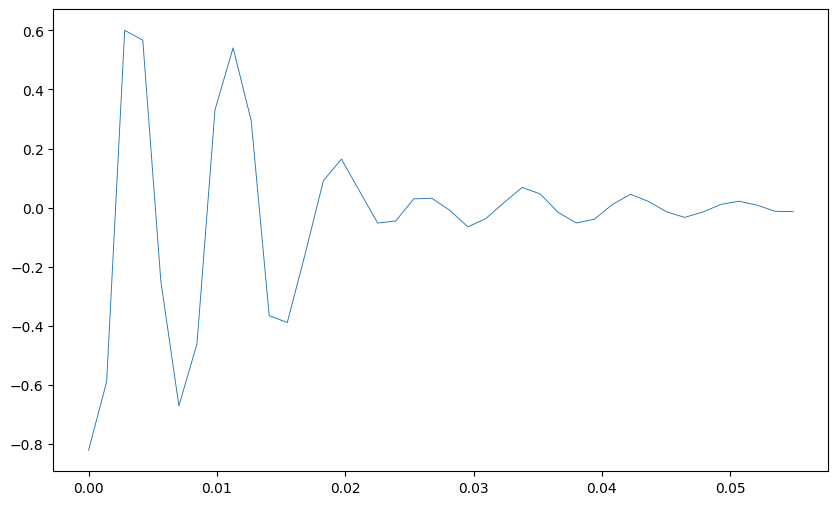

In [17]:
z = diag.z_axis(data.witnessInsitu)

witness_centroid_xi = -12.89
centroid_idx = np.argmin(abs(z - witness_centroid_xi))


# plt.plot(z, data.getZ(Ez_lev1, info_lev1))
# plt.plot(z, ExmBy_0)
wake_centroid = []
for step in range(0, 400, 10):
    ExmBy_1 = data.getZ(data.ts.get_field(field = 'ExmBy' + data.lv1, iteration = step)[0], info_lev1)
    wake_centroid.append(ExmBy_1[centroid_idx])
    
    # plt.scatter(z, ExmBy_1)

plt.close()
plt.figure(figsize=(10, 6))

plt.plot(time[::10], wake_centroid)

plt.show()

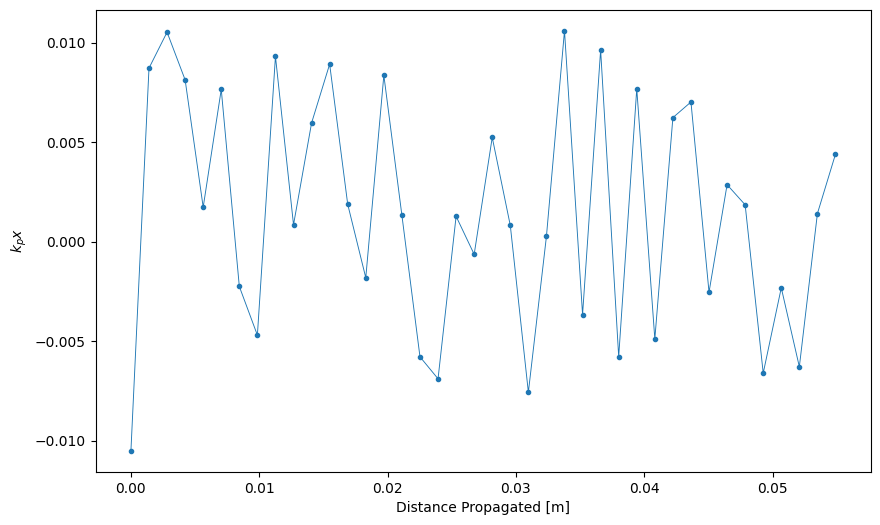

In [109]:
plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time[::10], wake_centroid_x, '.-')
plt.xlabel('Distance Propagated [m]')
plt.ylabel('$k_p x$')
plt.show()

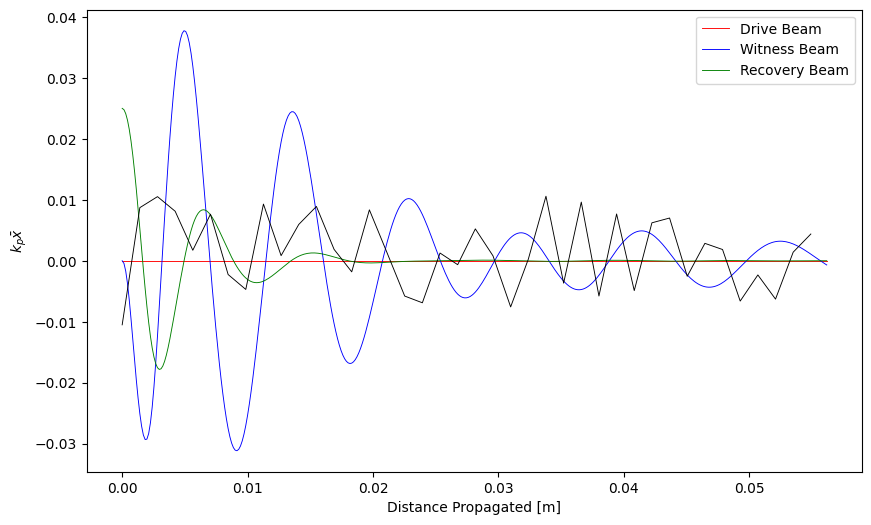

In [93]:
plt.close()
plt.figure(figsize = (10, 6))
plt.plot(time, [p_driveInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'Drive Beam', c = 'r')
plt.plot(time, [p_witnessInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'Witness Beam', c = 'b')
plt.plot(time, [p_recoveryInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'Recovery Beam', c = 'g')
# plt.scatter(time[::10], wake_centroid_x, s = 4, c='k')
plt.plot(time[::10], wake_centroid_x, c='k')
plt.xlabel('Distance Propagated [m]')
plt.ylabel('$k_p\\bar{x}$')
plt.legend()
plt.show()

In [148]:
step = 10 # 0

s = 1.75
pd = .1

# ExmBy_lev0, info_lev0 = data.ts.get_field(field = 'ExmBy' + data.lv0, iteration = step)

for step in range(0, max_step+10, 10):
    if step == max_step:
        step = max_step-1
    
    ExmBy_lev1, info_lev1 = data.ts.get_field(field = 'ExmBy' + data.lv1, iteration = step)
    
    plt.close()
    fig, axs = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 6), dpi = 800) # , gridspec_kw={'width_ratios': [1.75, 1]})
    
    # im = axs.pcolormesh(info_lev0.z, info_lev0.x, ExmBy_lev0.T, cmap = 'RdBu', vmin = -s, vmax = s) # level 0
    im = axs.pcolormesh(info_lev1.z, info_lev1.x, ExmBy_lev1.T, cmap = 'RdBu', vmin = -s, vmax = s) # level 1
    
    axs.axvline(-12.89, c='k', ls='--')
    
    divider2 = make_axes_locatable(axs)
    cax2 = divider2.append_axes("right", size = "4%", pad = pd)
    cb2 = plt.colorbar(im, cax = cax2, extend = 'both')
    cb2.set_label(r'$(E_x - B_y)/E_0 $', fontsize = 18)
    
    axs.set_xlim(-17, -5)
    axs.set_xlabel(r'$k_p\xi$', fontsize = 18)
    
    ylim = .05
    axs.set_ylim(-ylim, ylim)
    axs.set_ylabel(r'$k_px$', fontsize = 18)
    
    axs.legend(['Positron Beam X-Centroid'], loc='upper left')
    plt.suptitle(f'Step: {step} \n Distance Propagated: {time[step][0]:.2f} m')
    
    plt.savefig(f'/scratch/project_465001379/varverak/images/wake_centroid_{step}.png', dpi = 800, bbox_inches = 'tight')
    
    plt.close()

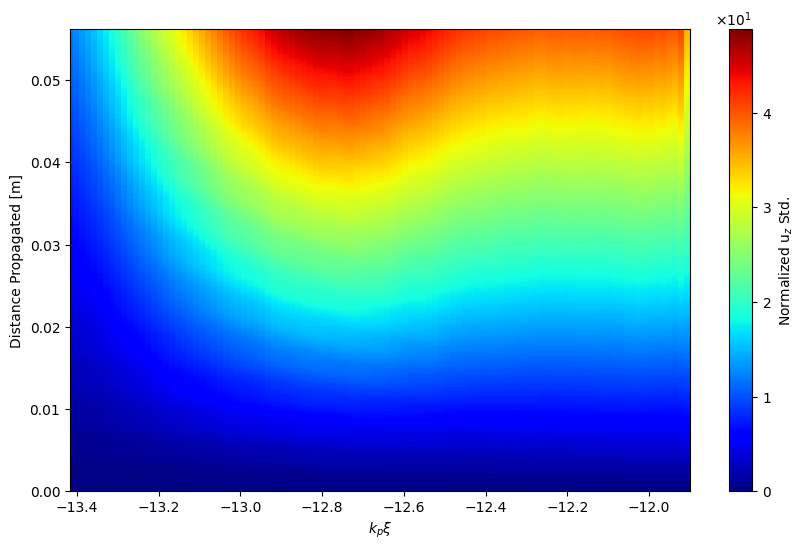

In [24]:
zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time, [diag.normalized_momentum_std(p_witnessInsitu[step], direction='z')[0] for step in range(max_step)], cmap='jet')

plt.ylim(0, time[-1])
# plt.xlim(-13, -10)
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'Normalized u$_z$ Std.')
plt.show()

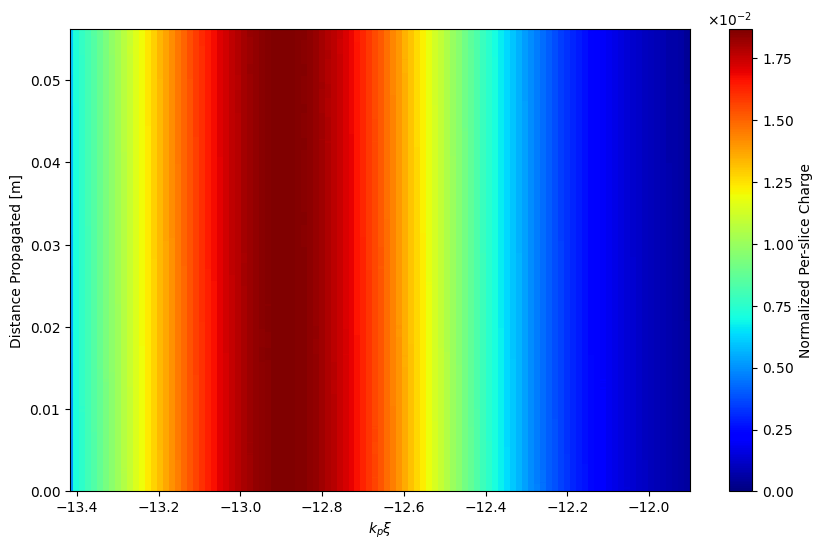

In [33]:
zAx = diag.z_axis(data.witnessInsitu)
beam = zAx[(data.witnessInsitu['sum(w)']!=0)[0]]

plt.close()
plt.figure(figsize=(10, 6))
img = plt.pcolormesh(diag.z_axis(data.witnessInsitu), time, [diag.per_slice_charge(p_witnessInsitu[step])[0] for step in range(max_step)], cmap='jet')

plt.ylim(0, time[-1])
# plt.xlim(-13, -10)
# plt.xlim(min(beam), max(beam))
plt.xlim(min(beam), -11.9)
plt.ylabel('Distance Propagated [m]')
plt.xlabel(r'$k_p\xi$')
cb2 = plt.colorbar(img)
cb2.formatter.set_useMathText(True)
cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'Normalized Per-slice Charge')
plt.show()